# Chart individual seat probabilities

## Python set-up

In [1]:
import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import common
import plotting

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter


In [2]:
%load_ext watermark
%watermark --machine --python --iversions --conda

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.10.1
pandas    : 2.2.3
numpy     : 2.2.4
re        : 2.2.1



## Get data

In [3]:
FILE = "../betting-data/sportsbet-2025-electorate-betting.csv"
betting_df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['timestamp'])
print(f"data length: {len(betting_df)}")
print(f"data start: {betting_df['timestamp'].min()}")
print(f"data end: {betting_df['timestamp'].max()}")
print(f"data columns: {betting_df.columns}")

data length: 986
data start: 2025-03-30 23:21:13.467650
data end: 2025-03-31 08:32:21.908383
data columns: Index(['Unnamed: 0', 'seat', 'party', 'price', 'timestamp'], dtype='object')


## Plot distribution of simple overrounds

In [4]:
def capture_latest_overrounds(df: pd.DataFrame) -> pd.Series:
    """
    Capture the latest overrounds for each seat in the dataframe.
    The overround is calculated as the sum of the inverse of the prices for each party.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    """
    # Filter out rows with missing prices
    df = df.dropna(subset=['price'])
    
    # Calculate the overround for each seat
    overrounds = {}
    for seat in df.seat.unique():
        overrounds[seat] = (
            df[df.seat == seat]
            .dropna(subset=['price'])
            .pivot(index='timestamp', columns='party', values='price')
            .iloc[-1]
            .pipe(lambda x: 1 / x)
            .sum()
        )
    series = pd.Series(overrounds)

    odd = series[series < 1.05]
    if len(odd):
        print('We have some odd overrounds:')
        for seat in odd.index:
            print(seat, )
            print(df[df.seat == seat]
                .pivot(index='timestamp', columns='party', values='price')
                .iloc[-1]
            )
        print('-' * 30)

    return series

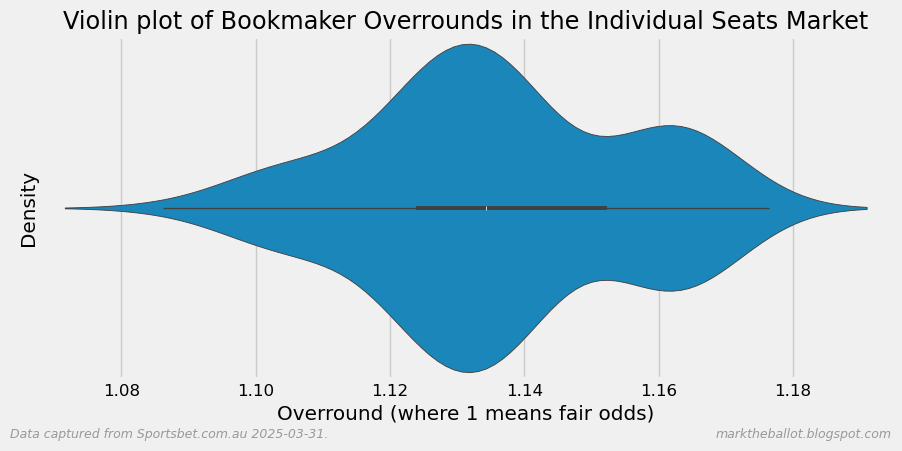

In [5]:
def plot_overrounds() -> None:
    """
    Plot the latest overrounds for each seat in the dataframe.
    """
    overround_series = capture_latest_overrounds(betting_df)
    ax = sns.violinplot(
        x=overround_series,
        orient='h'
    )
    title = 'Violin plot of Bookmaker Overrounds in the Individual Seats Market'
    plotting.finalise_plot(
        ax, 
        title=title, 
        ylabel='Density', 
        xlabel='Overround (where 1 means fair odds)',
        rfooter='marktheballot.blogspot.com',
        lfooter='Data captured from Sportsbet.com.au '
        + f'{betting_df["timestamp"].max().date()}. ',
        show=True
    )


plot_overrounds()

## Identify seats of interest

In [6]:
def calc_probability(df:pd.DataFrame, seat:str) -> pd.Series:

    """
    Calculate the probability of winning for each party in a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to calculate probabilities for.
    Returns a Series with party names as index and probabilities as values.
    """
    # Filter the dataframe for the given seat
    df = df[df.seat == seat]
    
    # Check if the dataframe is empty
    if df.empty:
        print(f"No data for seat {seat}")
        return None

    # get seat probabilities - treat for favourite-longshot bias
    seat_probs = (
        df[df.seat == seat]
        .dropna(subset=['price'])
        .pivot(index='timestamp', columns='party', values='price')
        .sort_index(ascending=True)

        # Favourite-Longshot Bias management
        # NOTE: change method statement at the end of this statement
        .pipe(lambda x: x * np.sqrt(x)) 
        .dropna(how='all', axis=1)
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))  # normalise
    ) * 100  # per cent
    method = 'Favourite-Longshot Bias treatment: raw-odds * sqrt(raw-odds)'

    return seat_probs, method 

In [7]:
def colourise(s:str) -> tuple[str, str]:
    """standard color and marker scheme for parties."""

    settings = {
        'coalition': ['royalblue', 's'],
        'labor':     ['#dd0000', 'd'],
        'green':     ['mediumseagreen', 'o'],
        'independent': ['teal', 'v'],
        'one nation': ['darkorchid', '^'],
        'jacqui lambie': ['darkorange', '>'],
        'katter': ['hotpink', '>'],
        'centre alliance': ['brown', '>'],
        'other': ['skyblue', '<'],
    }
    for party in settings:
        if party in s.lower():
            return settings[party]
    return ['cornflowerblue', '*']


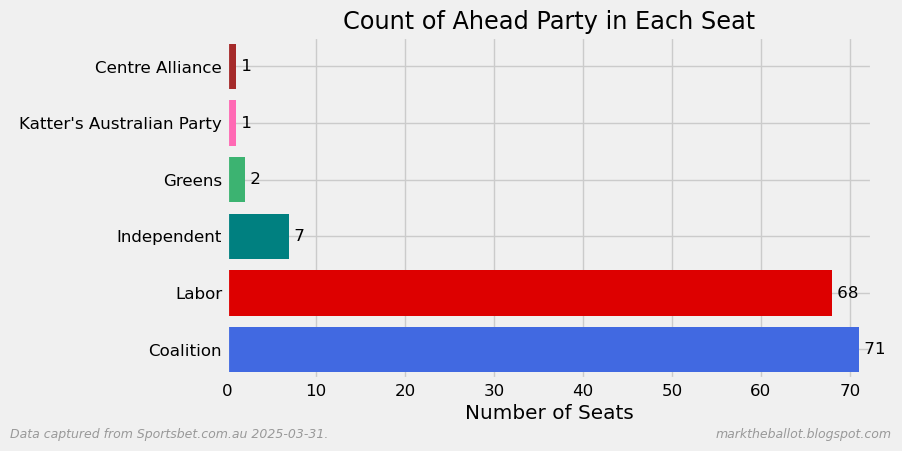

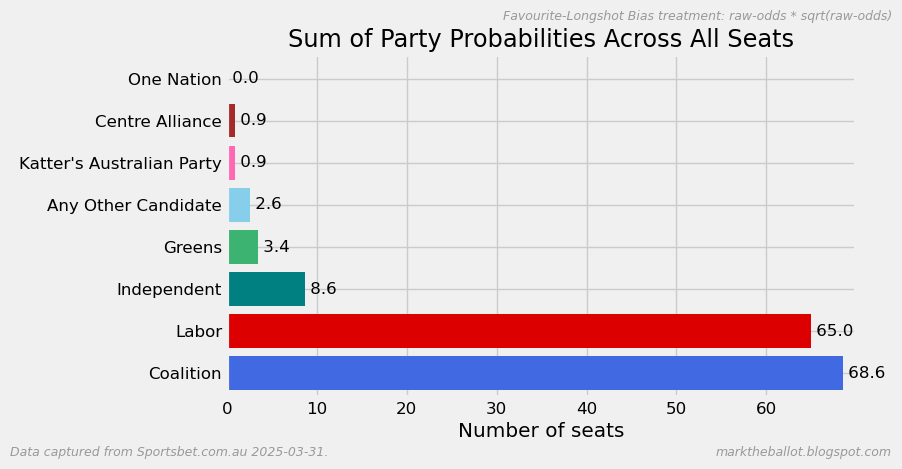

Close seats:


index  Top probability %        ahead
2    Brisbane (QLD)               35.1        Labor
13  Macnamara (VIC)               48.8        Labor
10    Kooyong (VIC)               50.5    Coalition
0      Boothby (SA)               51.5        Labor
1   Bradfield (NSW)               53.0    Coalition
16  Robertson (NSW)               53.2    Coalition
17       Ryan (QLD)               55.0    Coalition
19     Tangney (WA)               55.5    Coalition
12      Lyons (TAS)               58.6    Coalition
9    Griffith (QLD)               59.3       Greens
5      Cowper (NSW)               60.5    Coalition
8   Goldstein (VIC)               60.5  Independent
15   Paterson (NSW)               60.9    Coalition
22      Wills (VIC)               61.3        Labor
4      Calare (NSW)               62.2    Coalition
14     McEwen (VIC)               62.6    Coalition
18     Solomon (NT)               62.7        Labor
20     Wannon (VIC)               65.4    Coalition
6       Curtin (WA)               66.2    Coalition
11    Lingiari (NT)               68.7    Coalition
7     Dunkley (VIC)               69.2        Labor
3       Bruce (VIC)               69.2        Labor
21    Werriwa (NSW)               69.2        Labor

Seats where Greens might be competitive:


Greens win probability %
Melbourne (VIC)                      93.7
Griffith (QLD)                       59.3
Macnamara (VIC)                      37.8
Wills (VIC)                          36.9
Ryan (QLD)                           33.4
Brisbane (QLD)                       29.1

Seats where Others might be competitive:


Others win probability %
Clark (TAS)                           98.5
Kennedy (QLD)                         95.6
Warringah (NSW)                       88.7
Indi (VIC)                            88.6
Mayo (SA)                             87.2
Wentworth (NSW)                       84.8
Fowler (NSW)                          75.8
Mackellar  (NSW)                      74.6
Goldstein (VIC)                       61.4
Kooyong (VIC)                         48.6
Bradfield (NSW)                       46.0
Cowper (NSW)                          38.6
Calare (NSW)                          36.8
Wannon (VIC)                          33.7
Curtin (WA)                           32.9
McPherson (QLD)                       25.9

In [8]:
groups = {"Coalition", "Labor", "Greens", "Others",}
individual_leaders = {}
all_seats_probs = {}
party_leaders = {}
for seat in betting_df.seat.unique():
    seat_probs, method = calc_probability(betting_df, seat)
    latest = seat_probs.iloc[-1].dropna()
    individual_leaders[seat] = latest.idxmax()
    party_leaders[seat] = re.sub("\(.*?\)", "", individual_leaders[seat]).strip()

    # let's group probabilities by party
    renamer = {x: re.sub("\(.*?\)", "", x).strip() for x in latest.index}
    groups = latest.rename(index=renamer)
    all_seats_probs[seat] = groups / 100  # convert to simplex


# Plotting the ahead party count
winners = pd.Series(party_leaders).value_counts()
colors = [colourise(x)[0] for x in winners.index]
_fig, ax = plt.subplots()
ax.barh(winners.index, winners, color=colors)
for i, v in enumerate(winners):
    ax.text(v, i, f' {v}', color='black', va='center', ha='left')
plotting.finalise_plot(
    ax,
    title='Count of Ahead Party in Each Seat',
    ylabel=None,
    xlabel='Number of Seats',
    rfooter='marktheballot.blogspot.com',
    lfooter='Data captured from Sportsbet.com.au '
    + f'{betting_df["timestamp"].max().date()}. ',
    show=True
)

# Plotting the party-probability sum
party_probs = pd.DataFrame(all_seats_probs).T.sum().sort_values(ascending=False)
assert (149.9 < party_probs.sum() < 150.1), "Probabilities do not sum to 150 seats"
colors = [colourise(x)[0] for x in party_probs.index]
_fig, ax = plt.subplots()
ax.barh(party_probs.index, party_probs, color=colors)
for i, v in enumerate(party_probs):
    ax.text(v, i, f' {v:0.1f}', color='black', va='center', ha='left')
plotting.finalise_plot(
    ax,
    title='Sum of Party Probabilities Across All Seats',
    ylabel=None,
    xlabel='Number of seats',
    rfooter='marktheballot.blogspot.com',
    lfooter='Data captured from Sportsbet.com.au '
    + f'{betting_df["timestamp"].max().date()}. ',
    rheader=method,
    show=True
)

# close seats
seat_probs = pd.DataFrame(all_seats_probs).T * 100
CLOSE_THRESHOLD = 70
close_seats = seat_probs[seat_probs.max(axis=1) <= CLOSE_THRESHOLD]
maxima = close_seats.max(axis=1).round(1)
ahead = close_seats.idxmax(axis=1)
results = pd.DataFrame({
    'Top probability %': maxima,
    'ahead': ahead,
})
results = results.reset_index().sort_values(by='Top probability %', ascending=True)
print("Close seats:")
display(results)

# Green ahead seats
GREEN_THRESHOLD = 25
greens = seat_probs['Greens']
green_competitive = greens[greens >= GREEN_THRESHOLD].sort_values(ascending=False).round(1)
print("Seats where Greens might be competitive:")
frame = pd.DataFrame(green_competitive)
frame.columns = ["Greens win probability %"]
display(frame)

# Others ahead
OTHER_THRESHOLD = 25
others = seat_probs.drop(columns=['Greens', 'Labor', 'Coalition']).sum(axis=1)
other_competitive = others[others >= OTHER_THRESHOLD].sort_values(ascending=False)
print("Seats where Others might be competitive:")
display(pd.DataFrame(other_competitive, columns=["Others win probability %"]).round(1))

## Plot seats

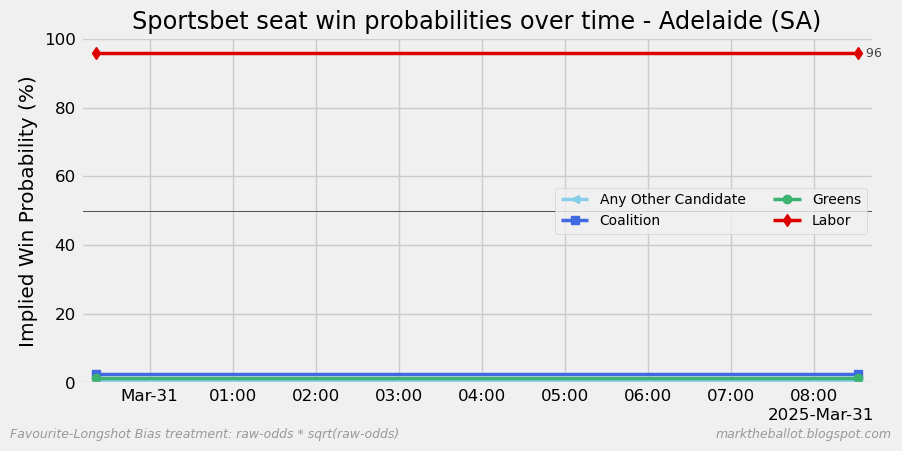

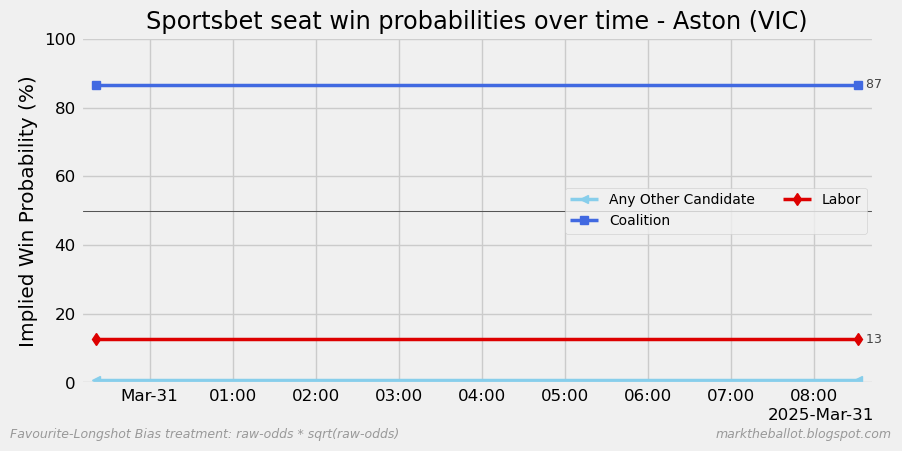

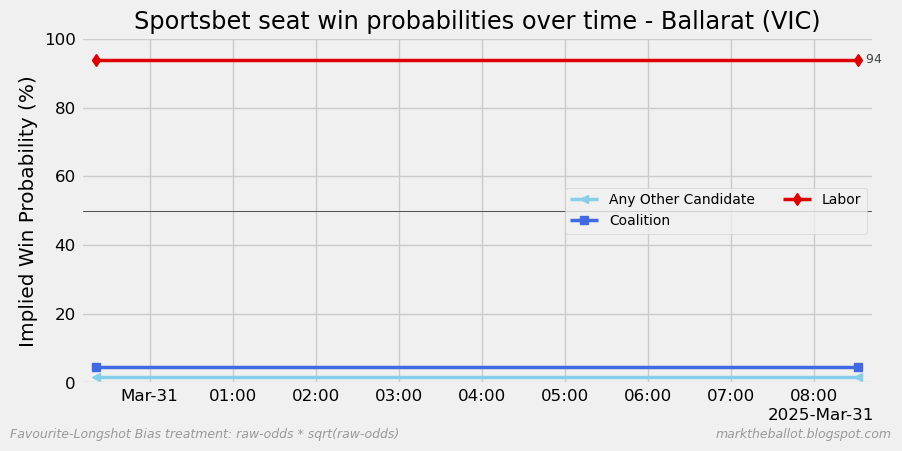

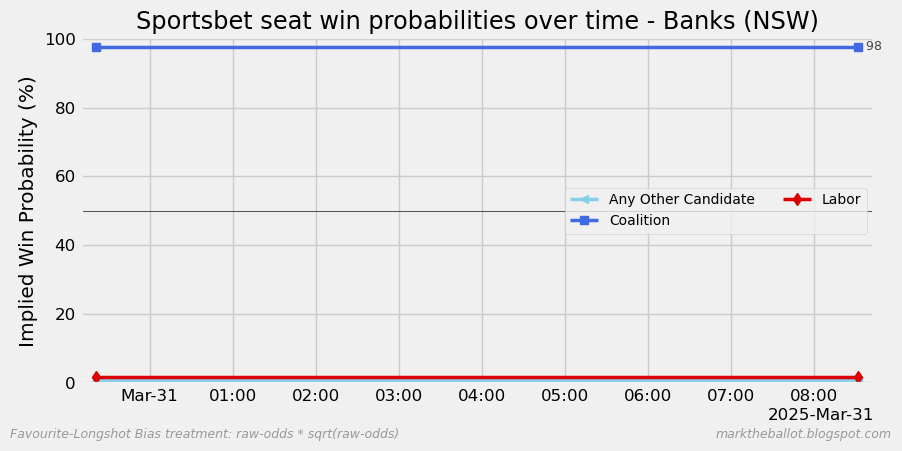

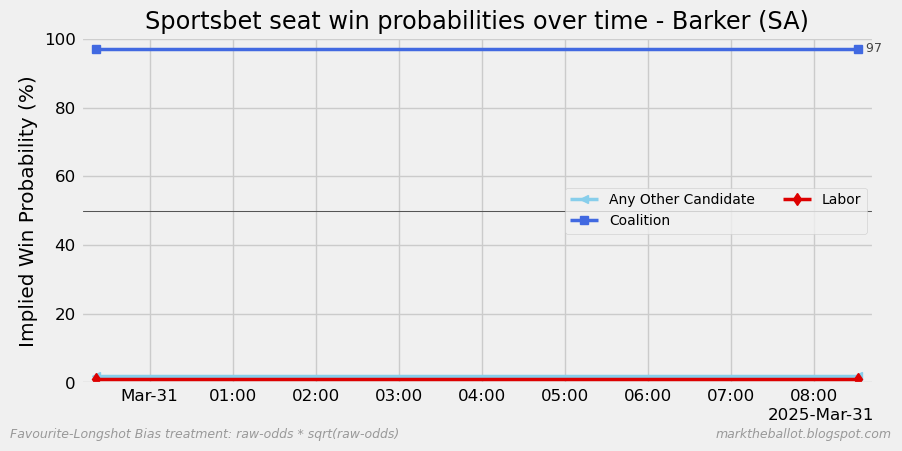

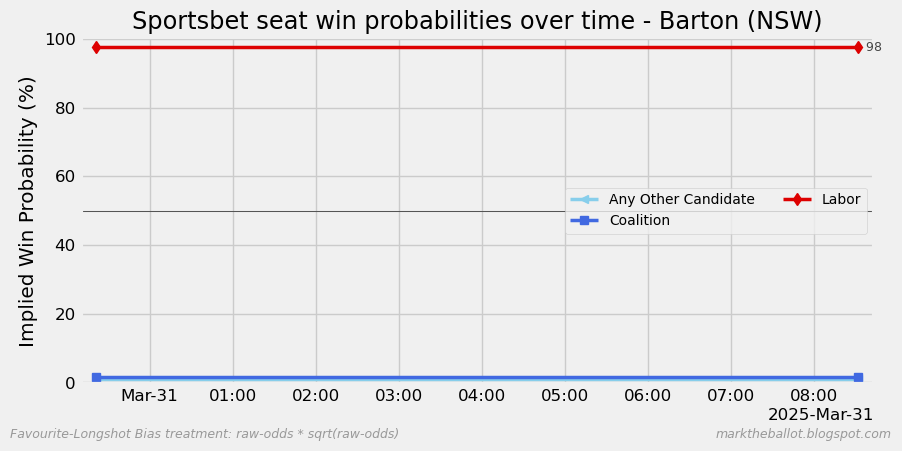

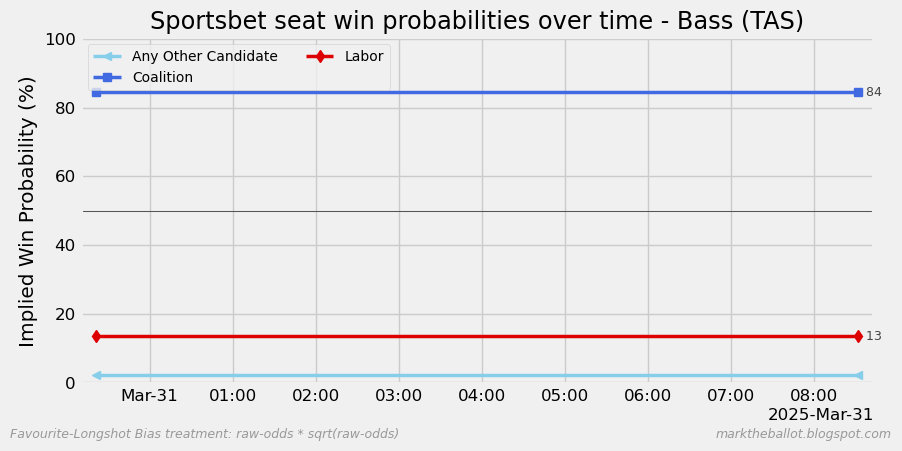

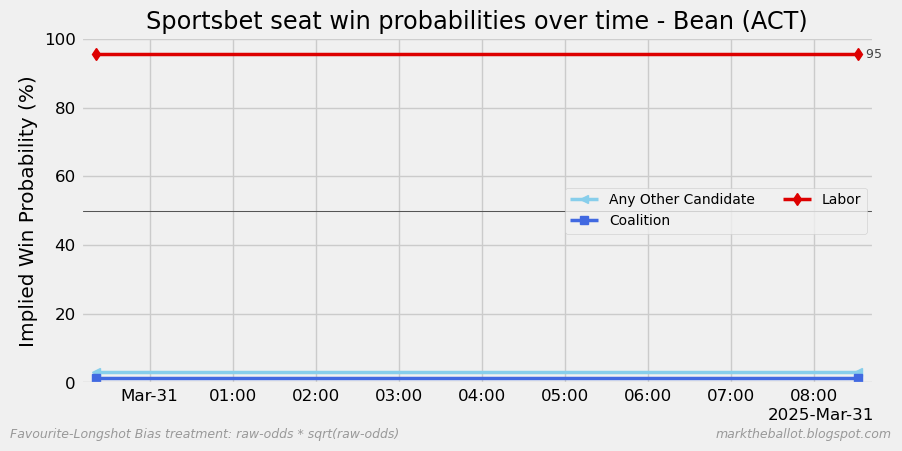

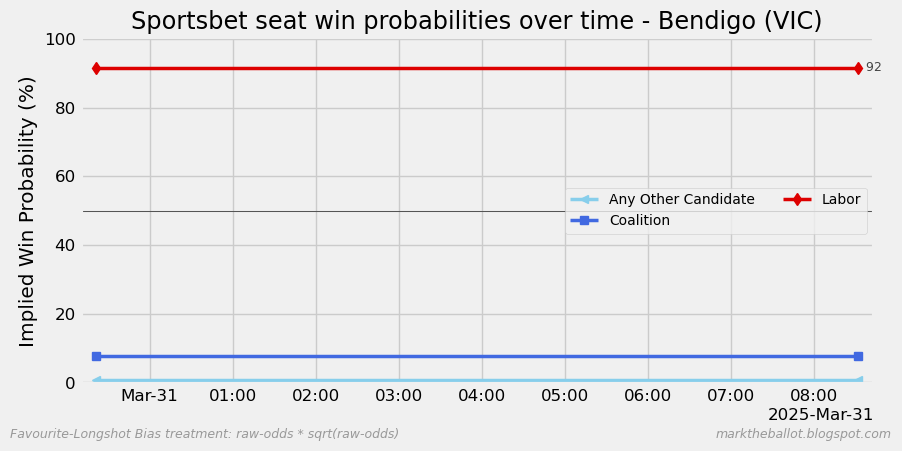

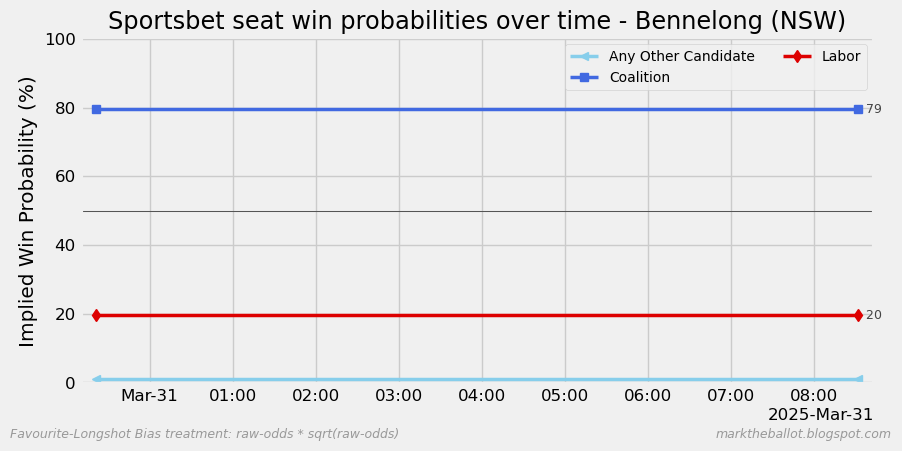

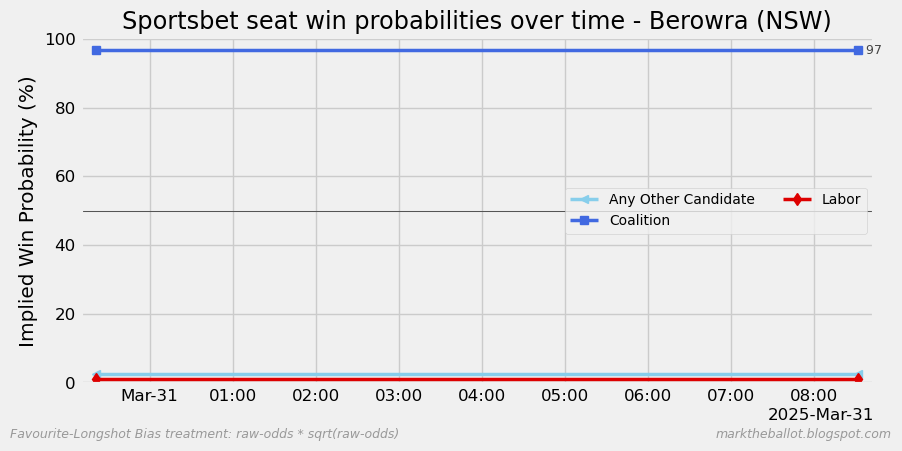

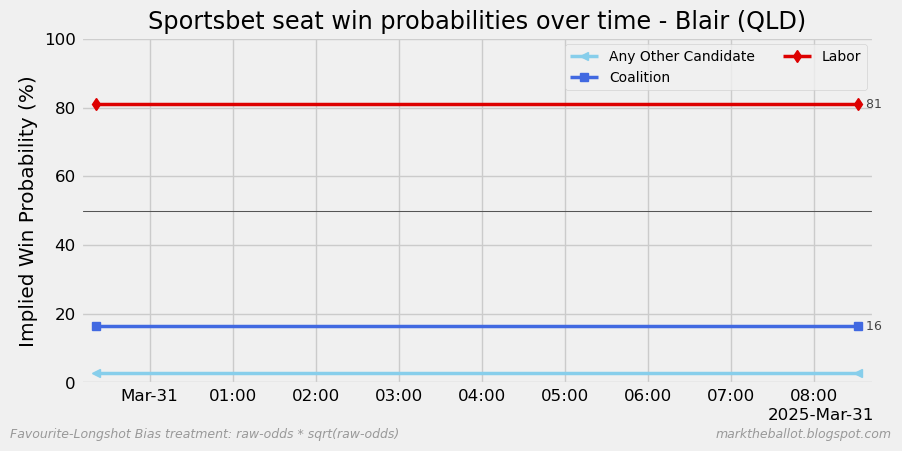

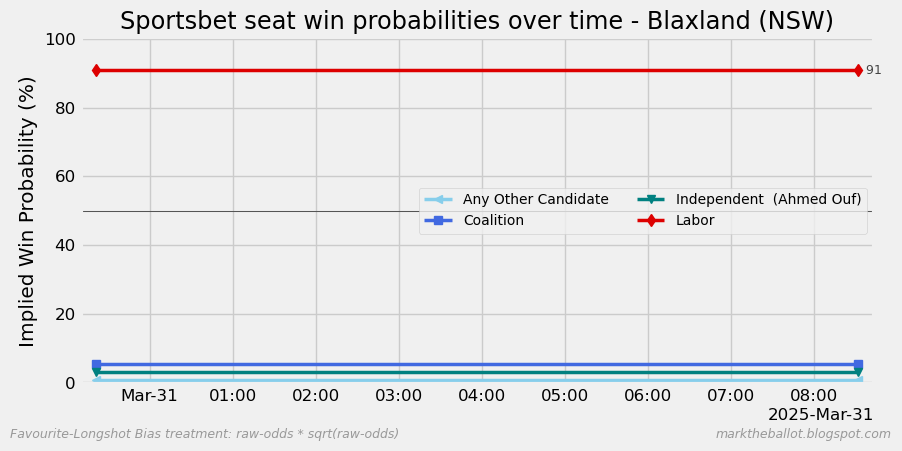

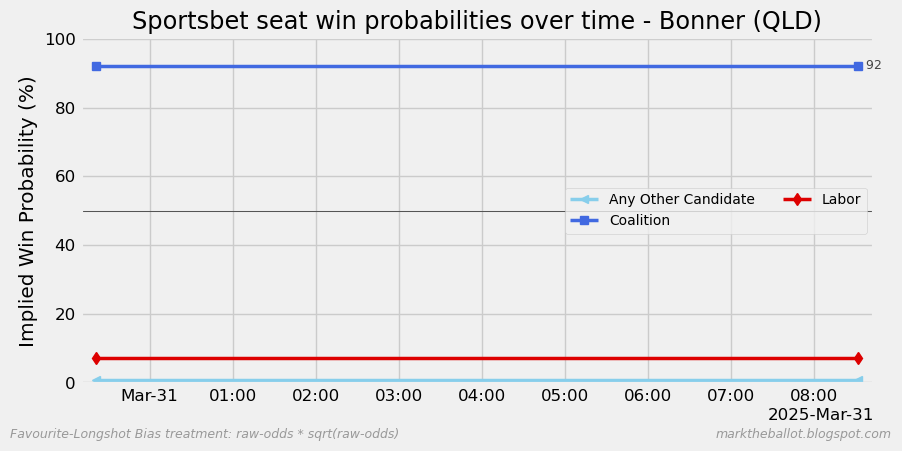

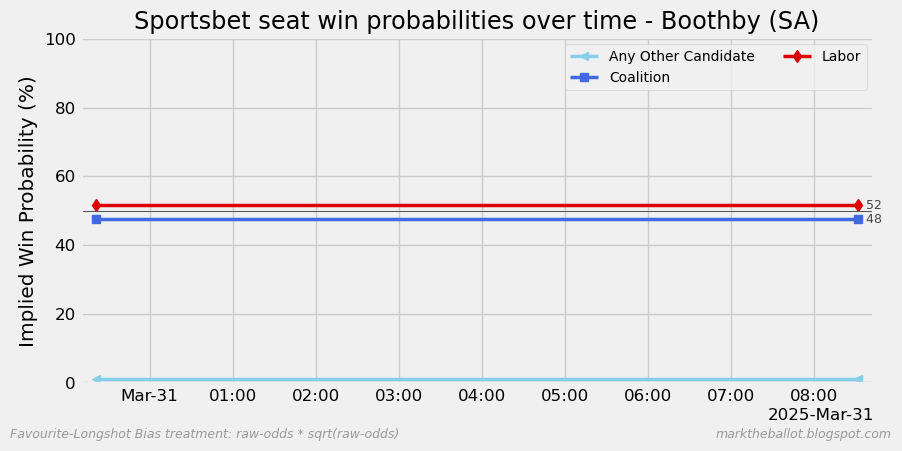

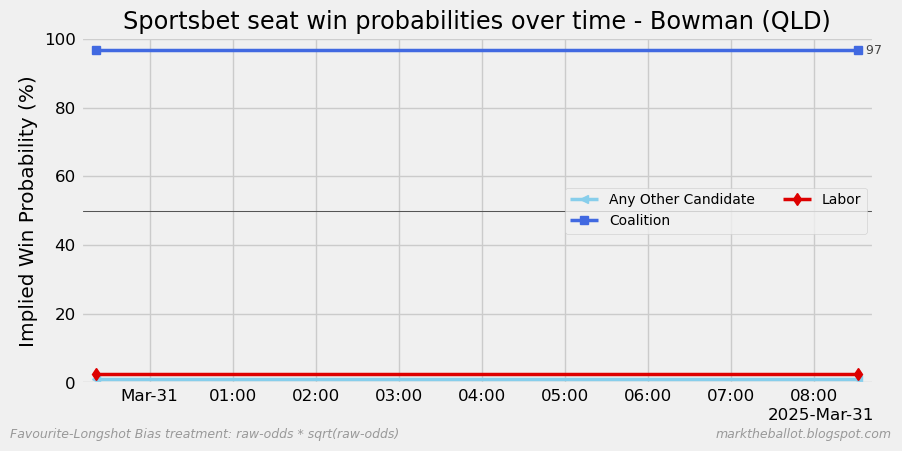

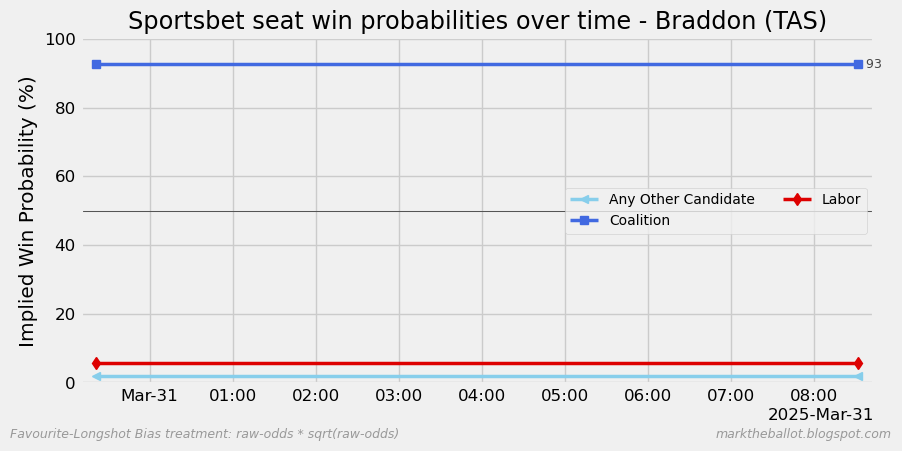

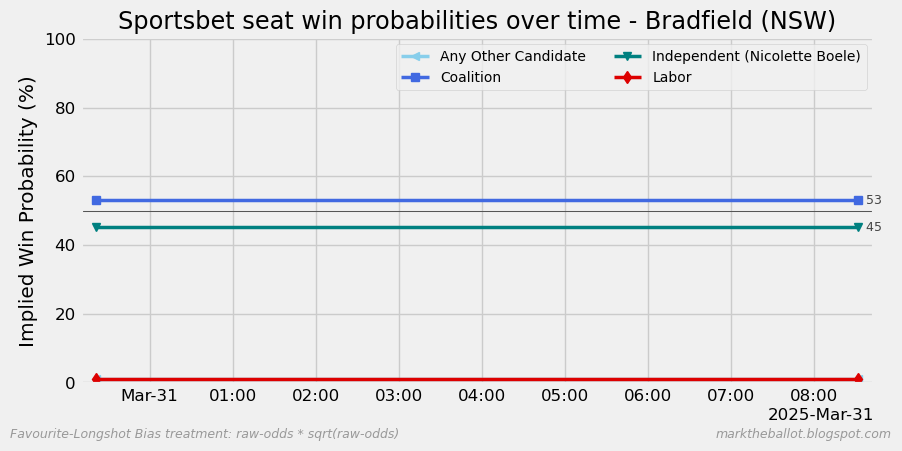

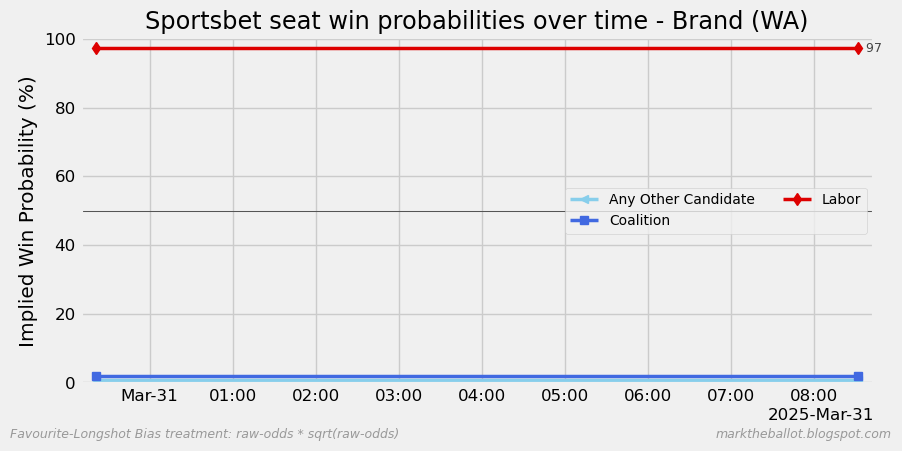

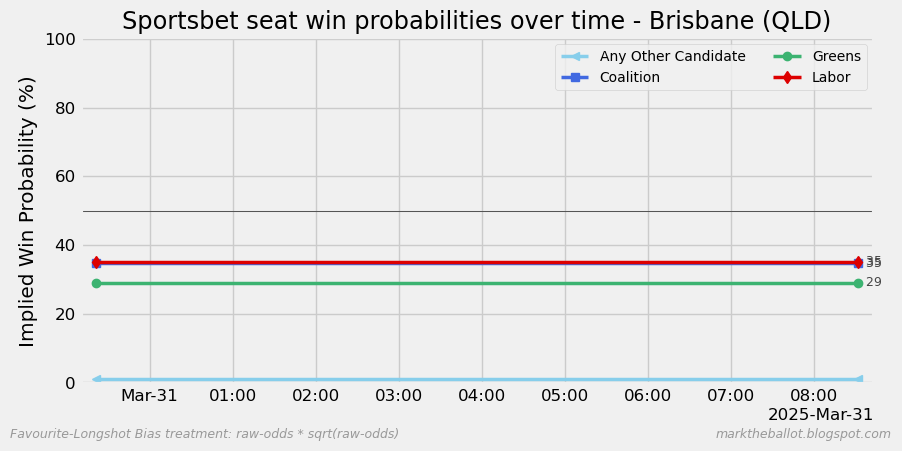

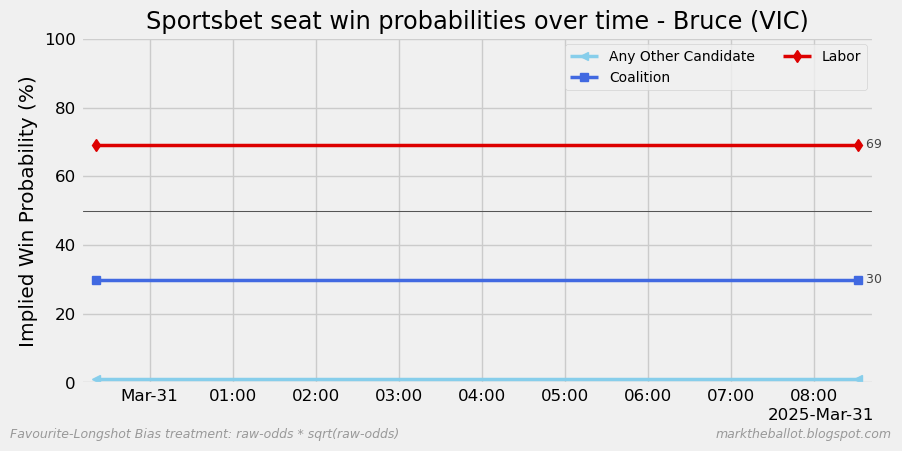

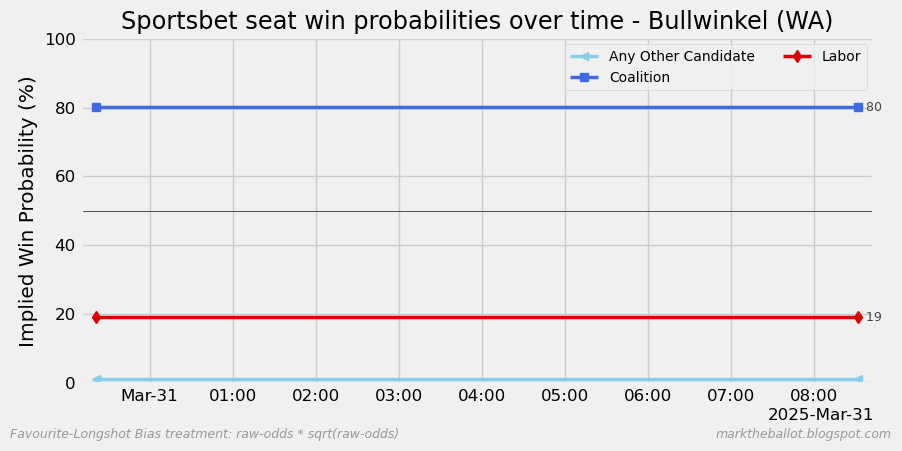

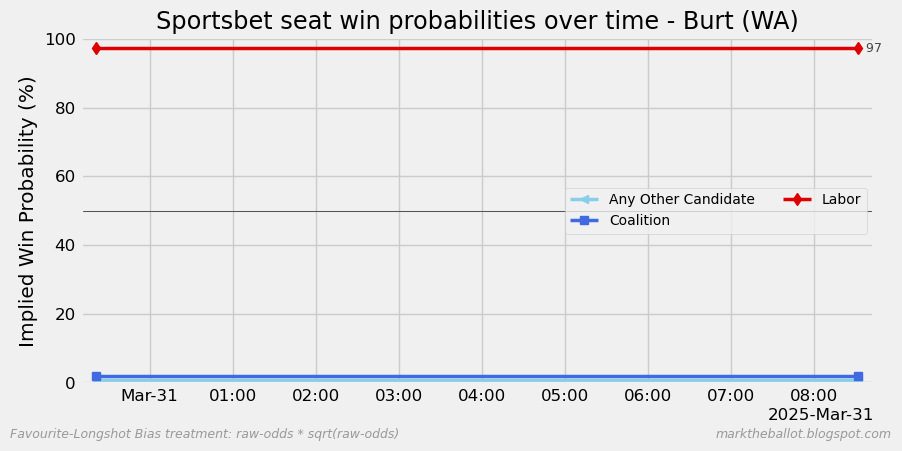

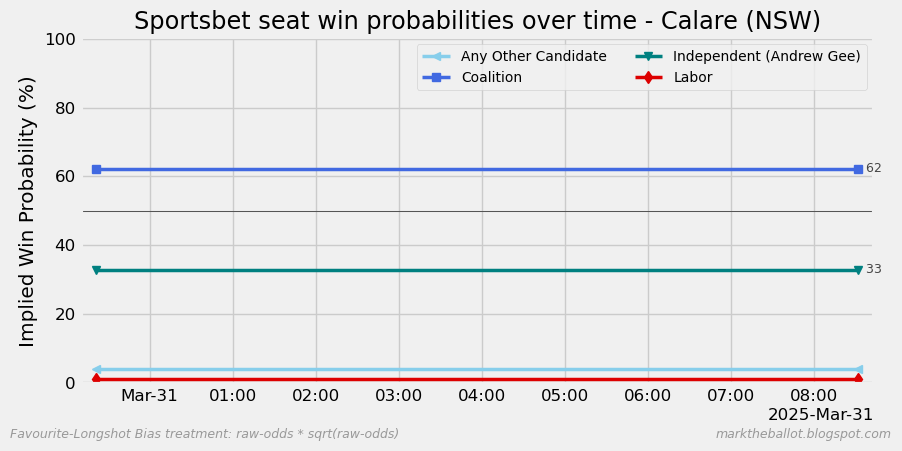

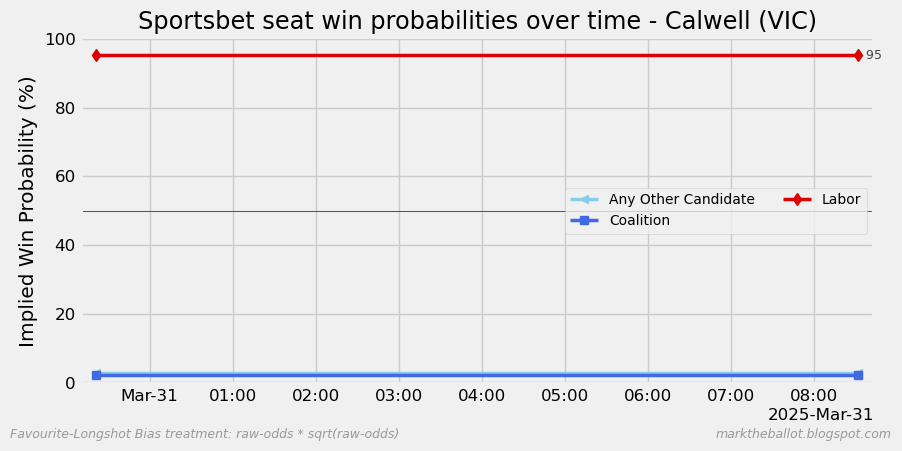

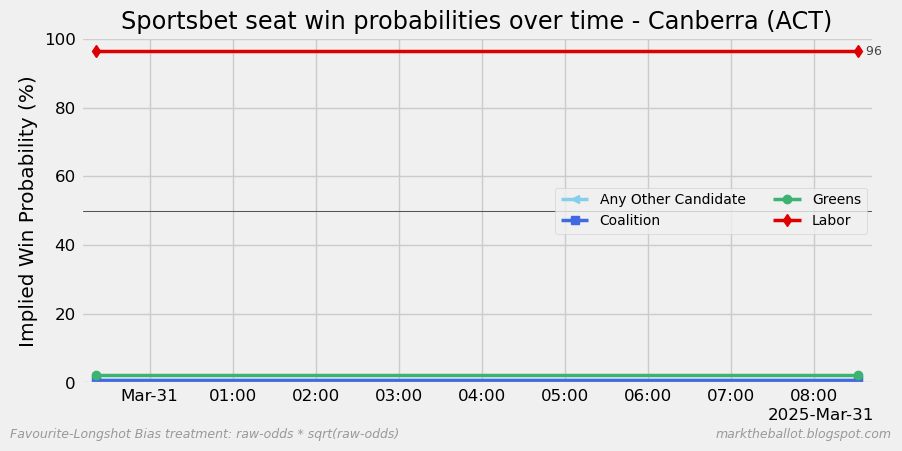

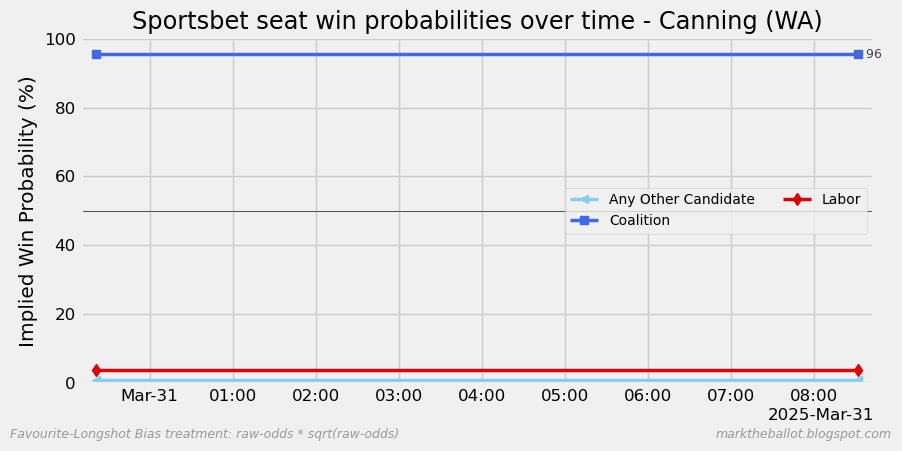

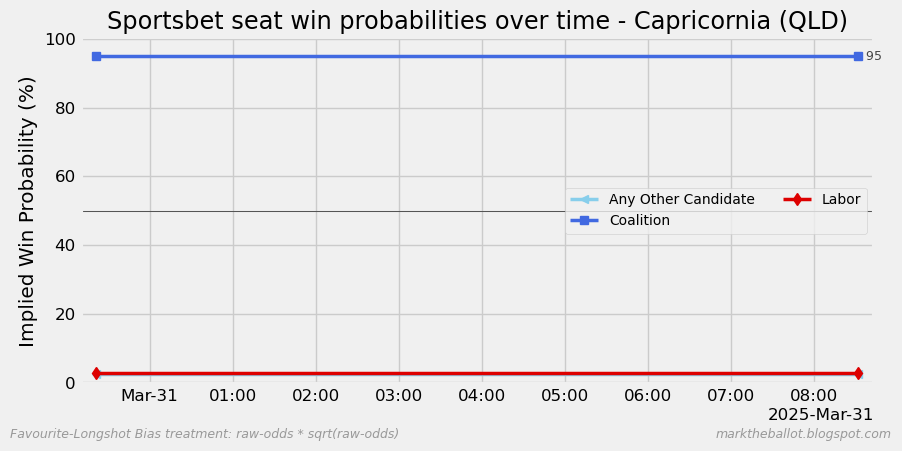

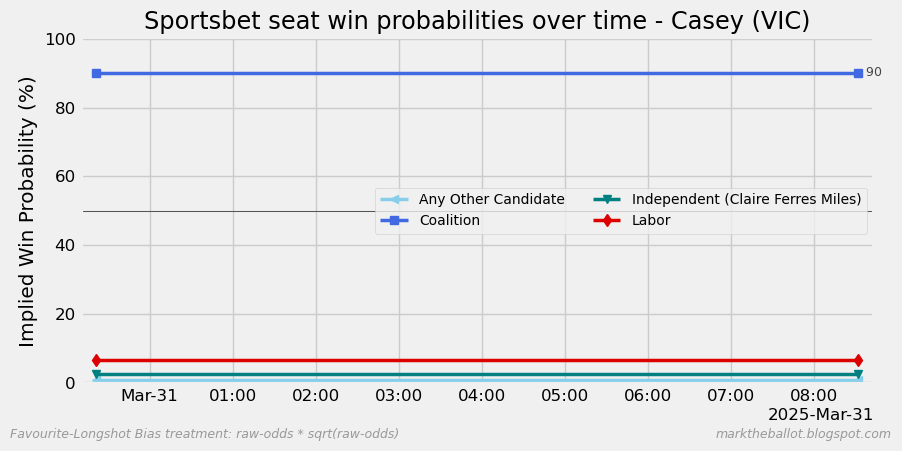

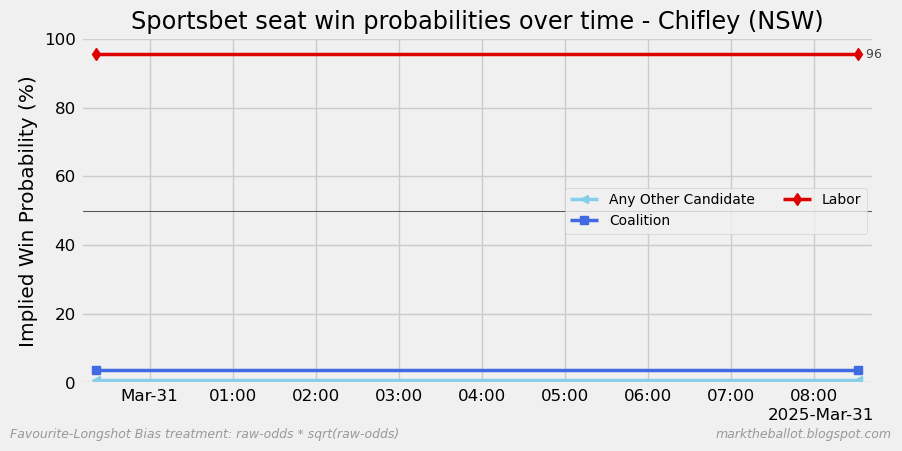

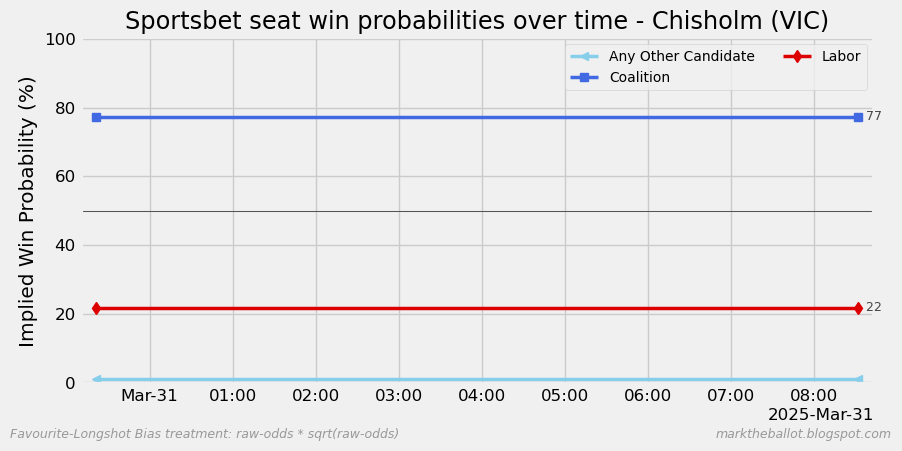

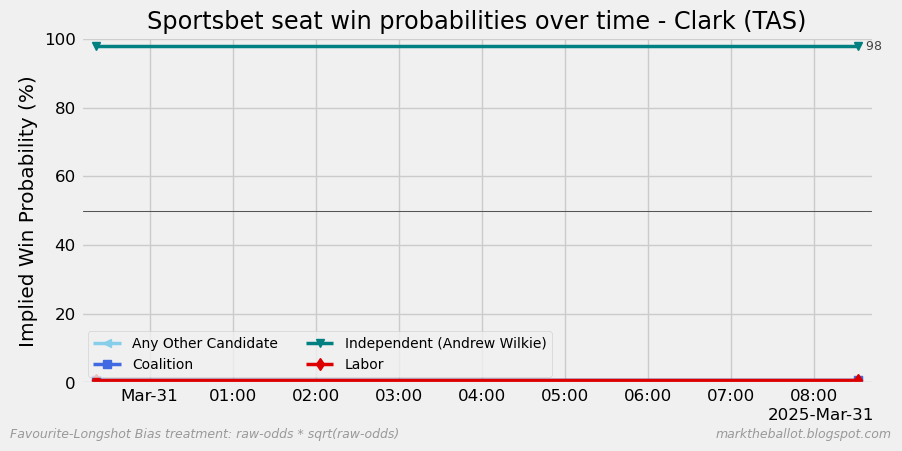

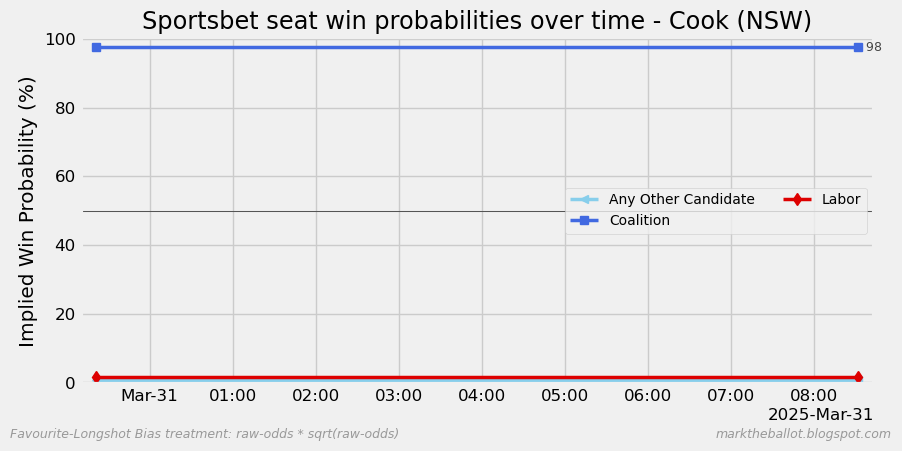

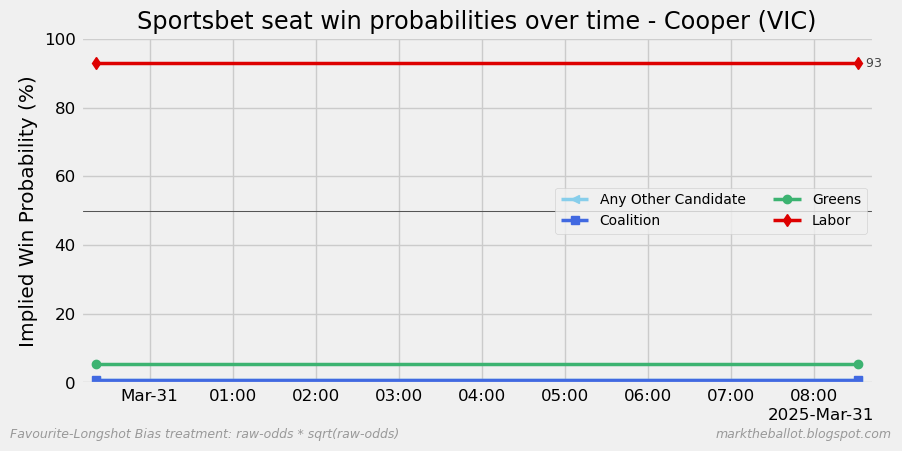

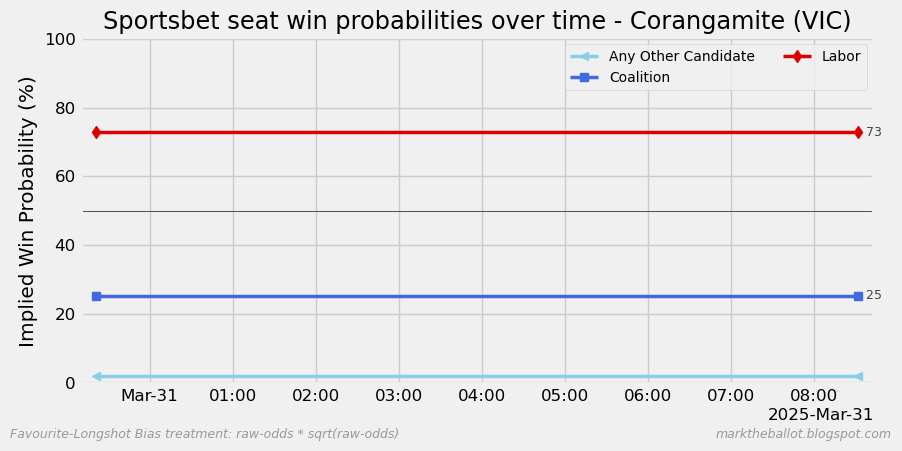

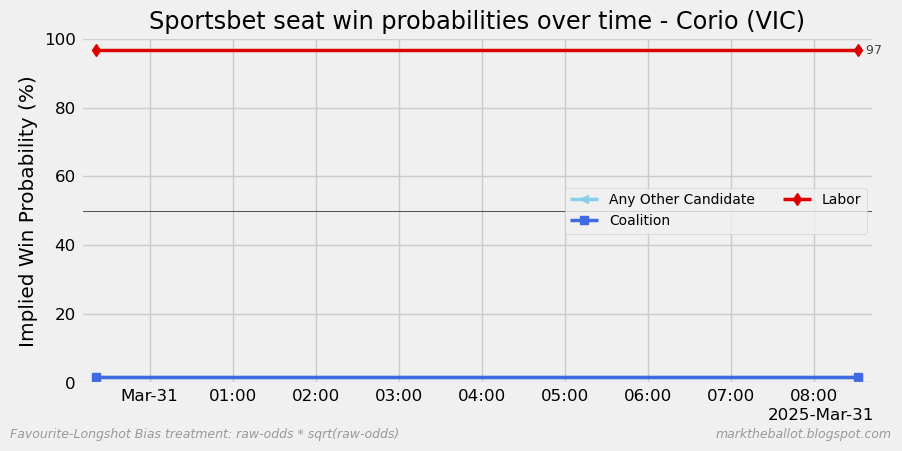

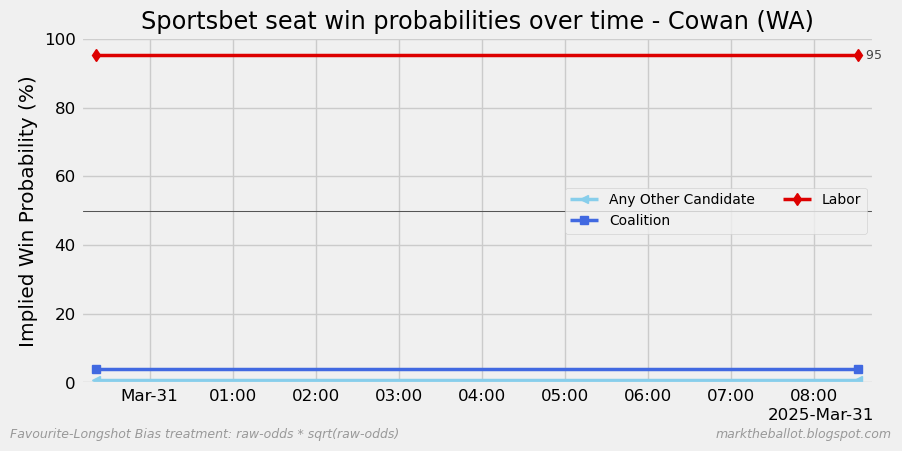

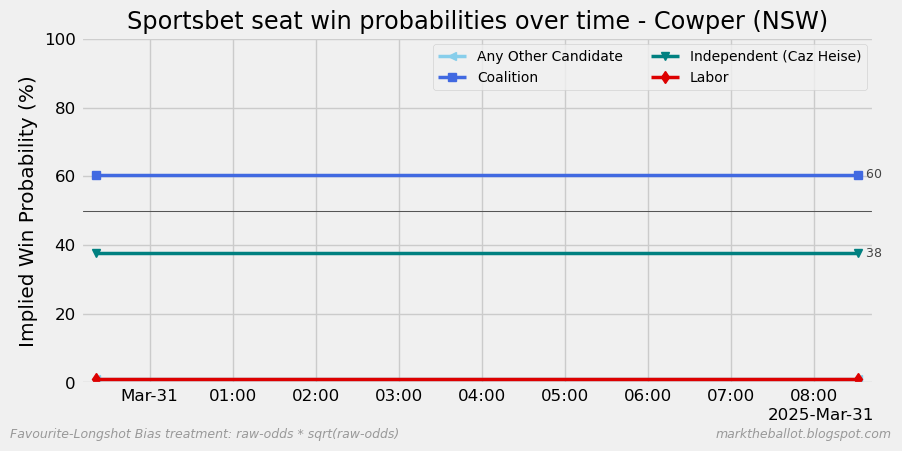

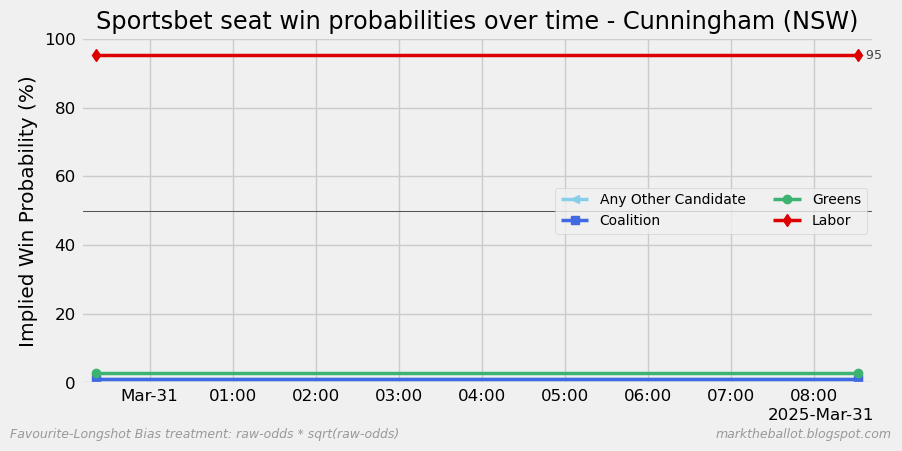

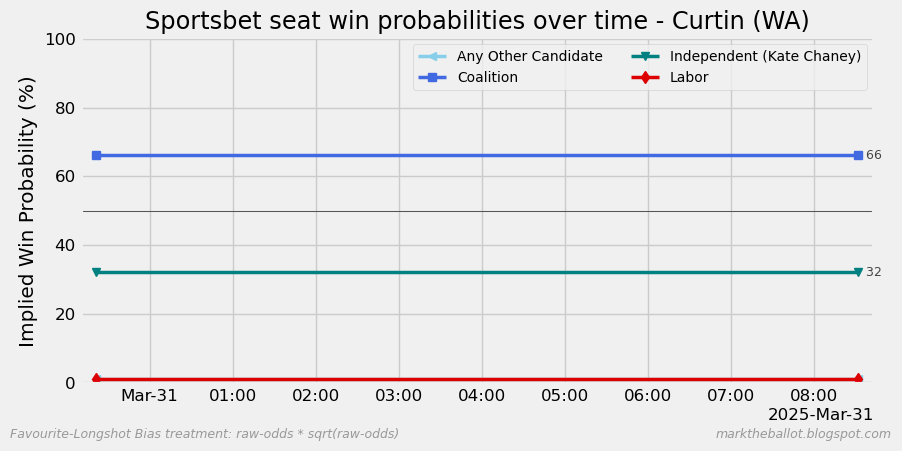

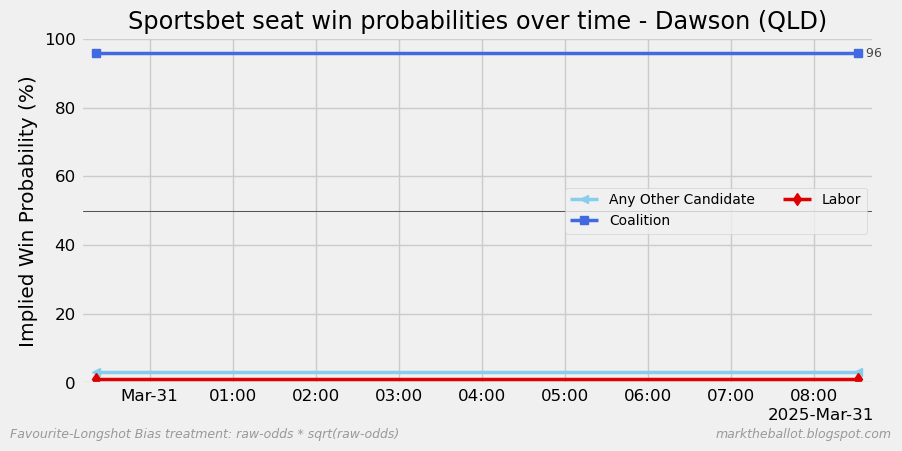

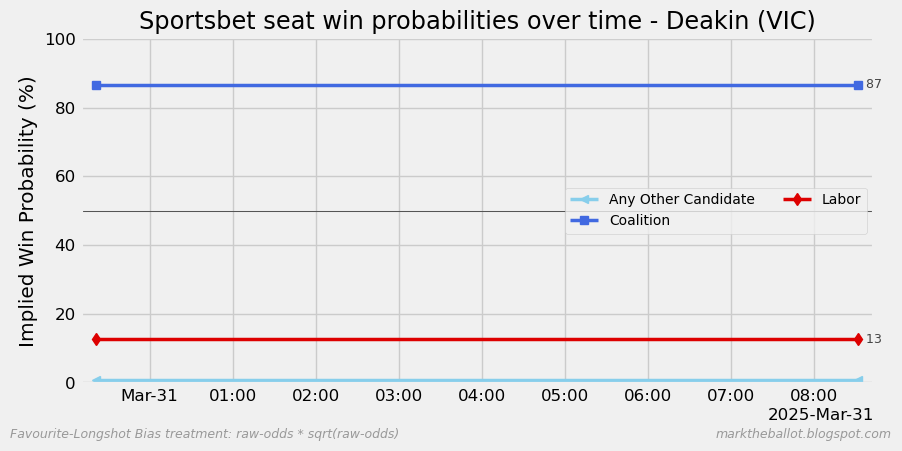

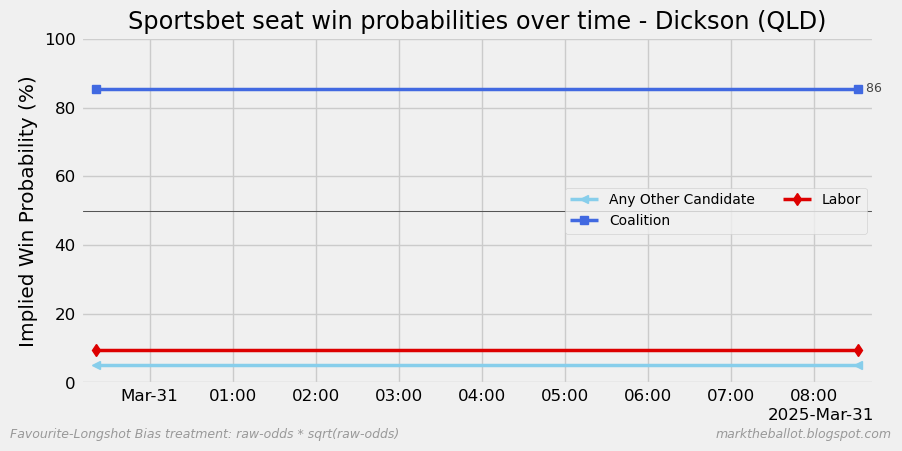

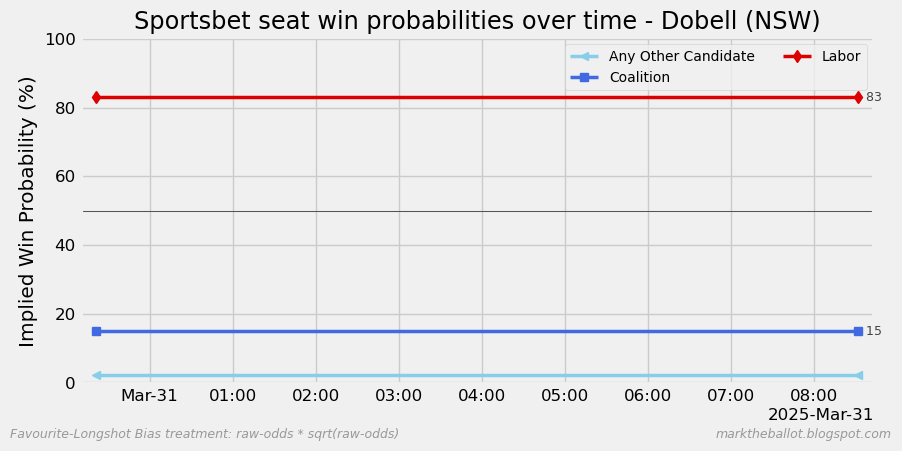

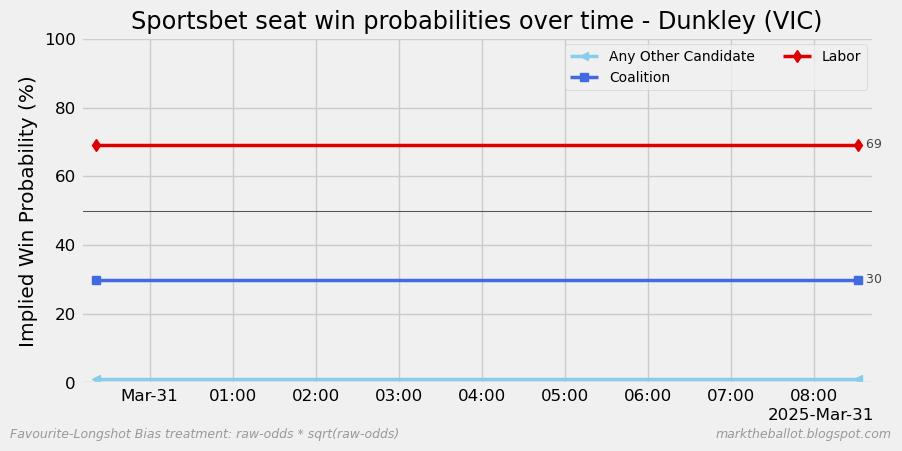

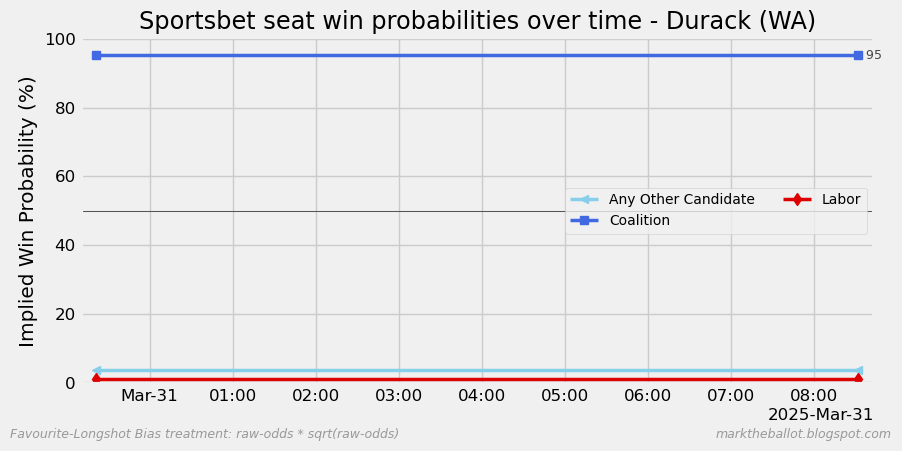

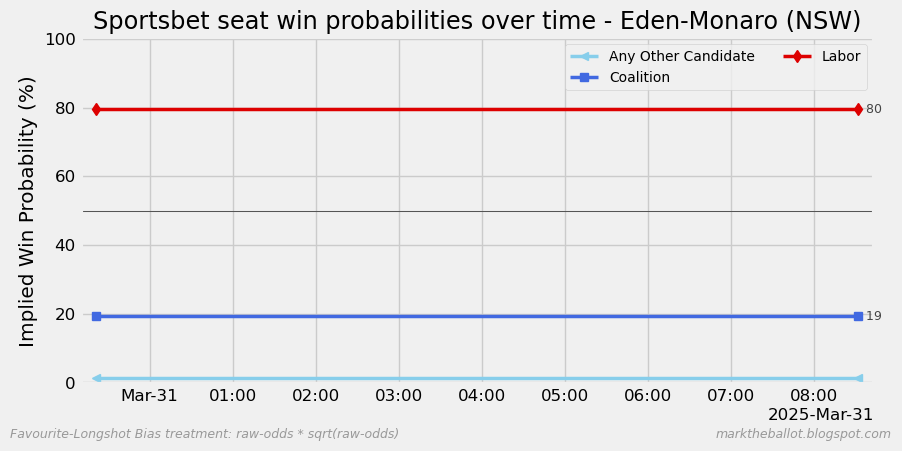

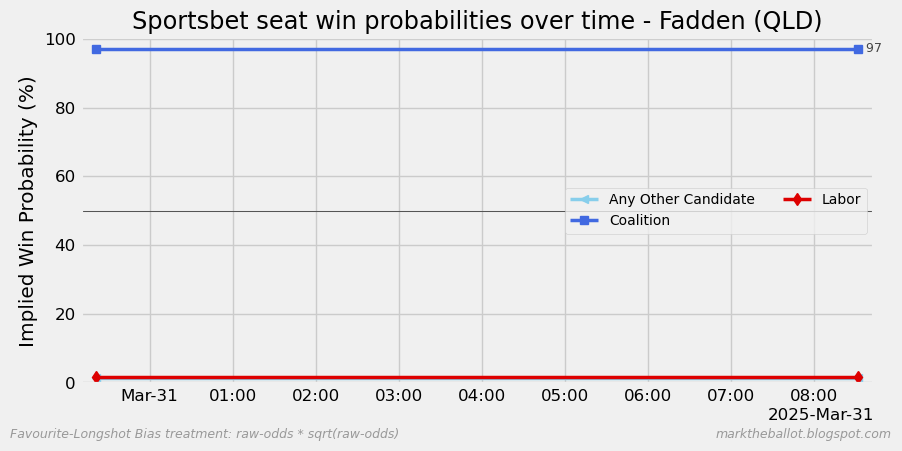

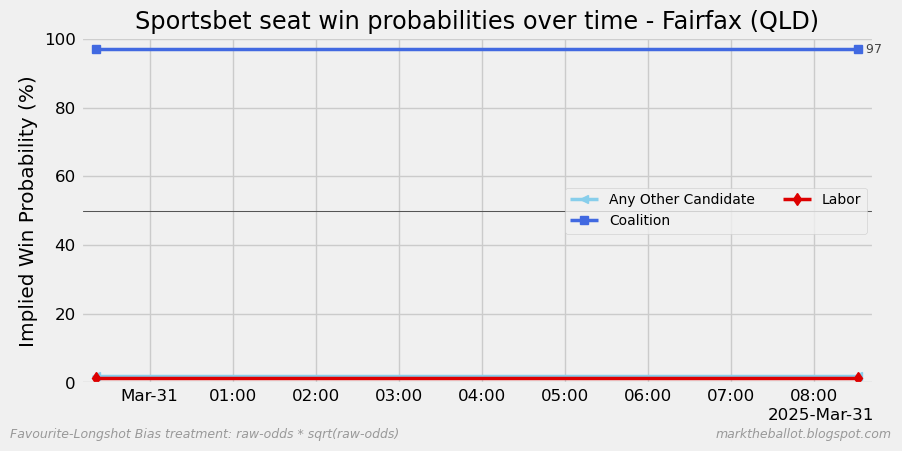

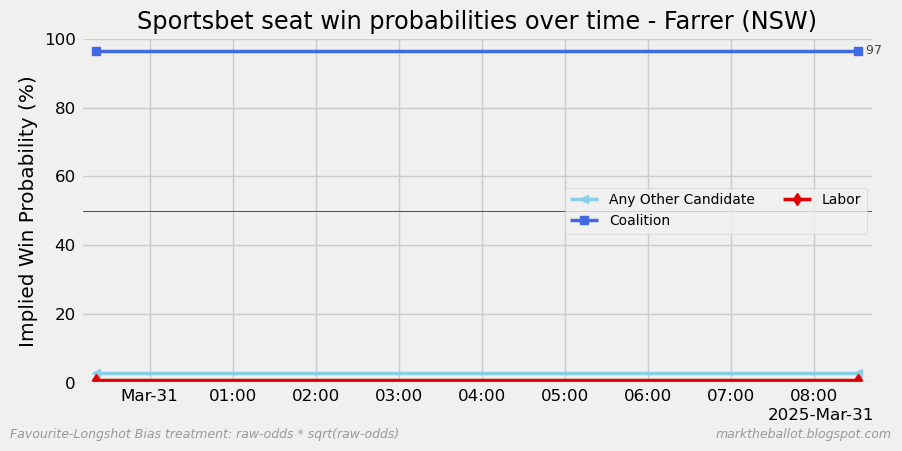

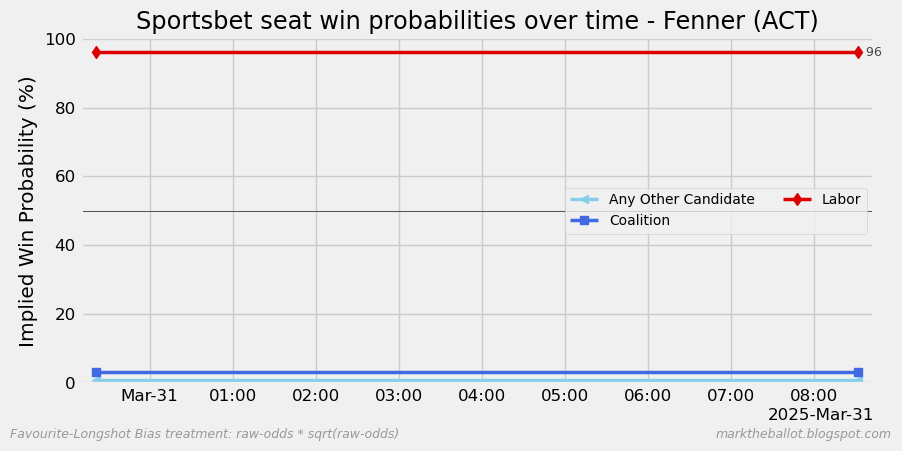

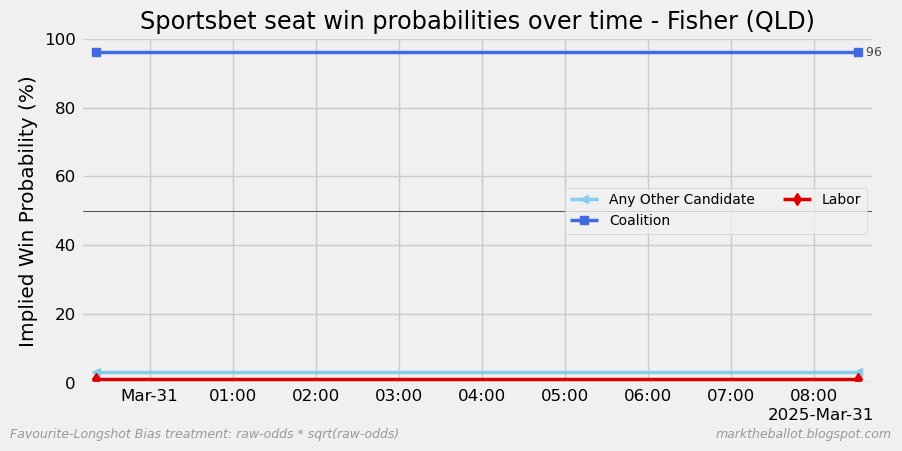

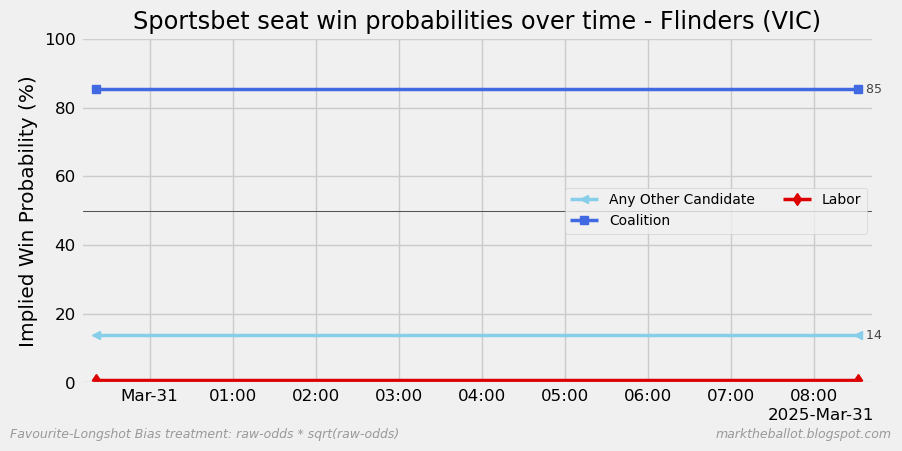

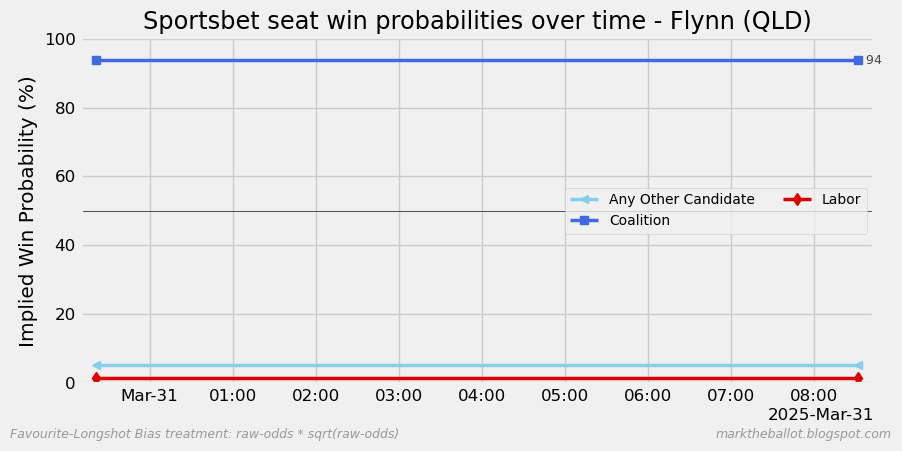

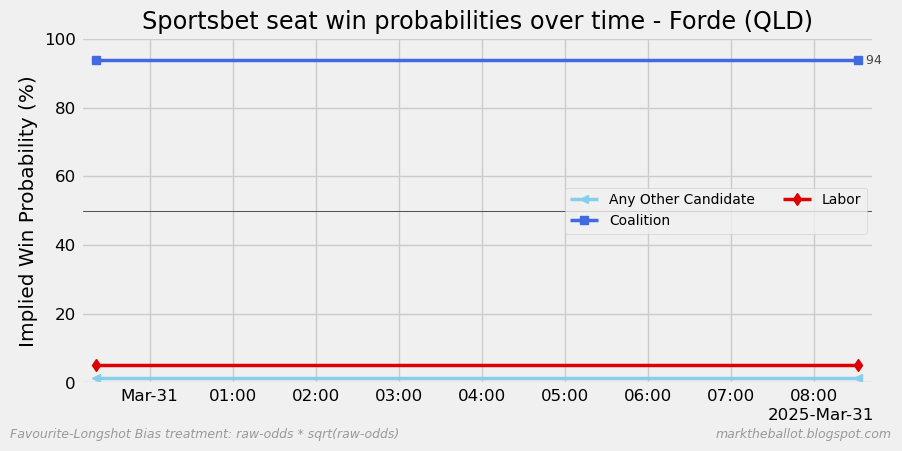

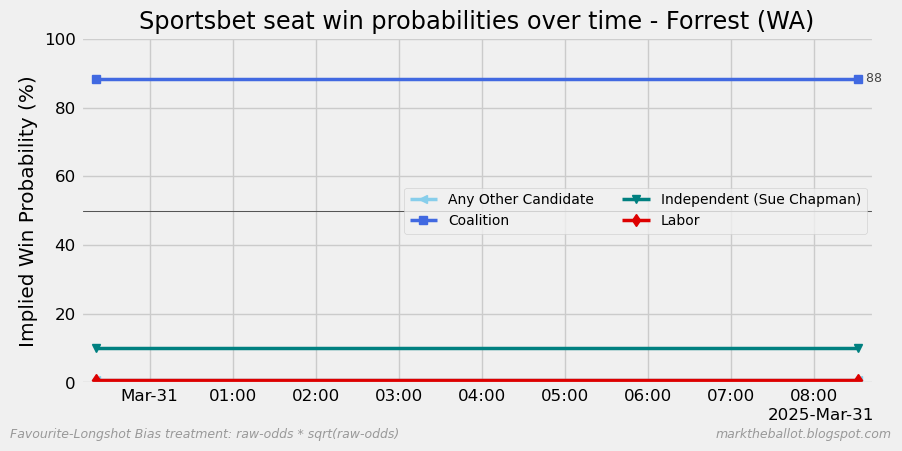

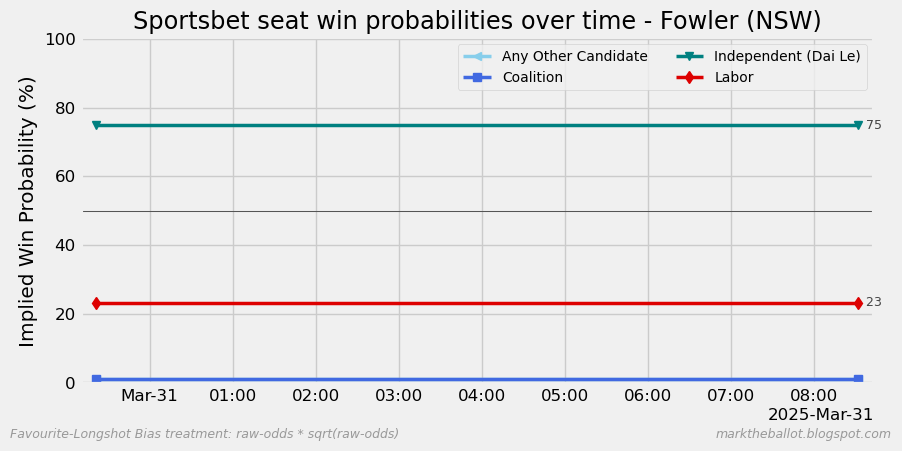

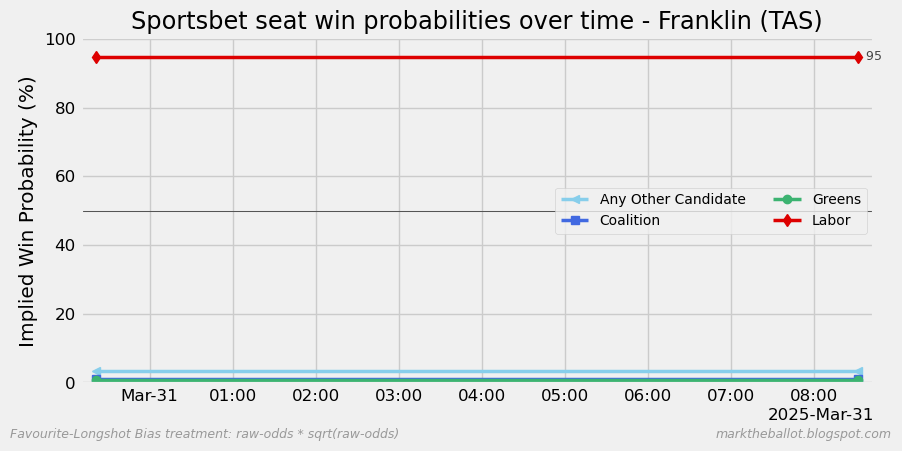

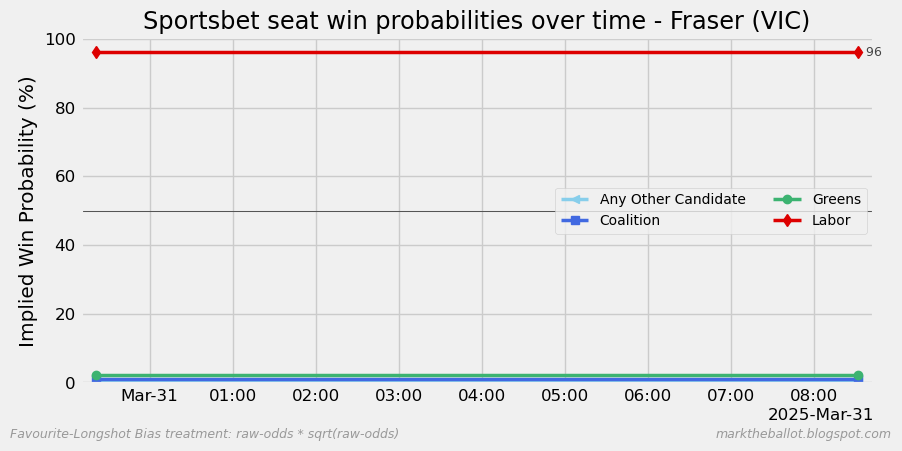

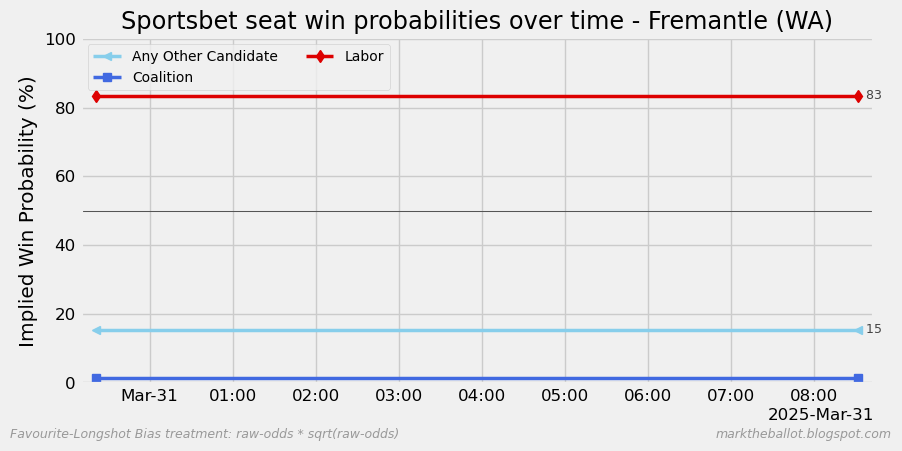

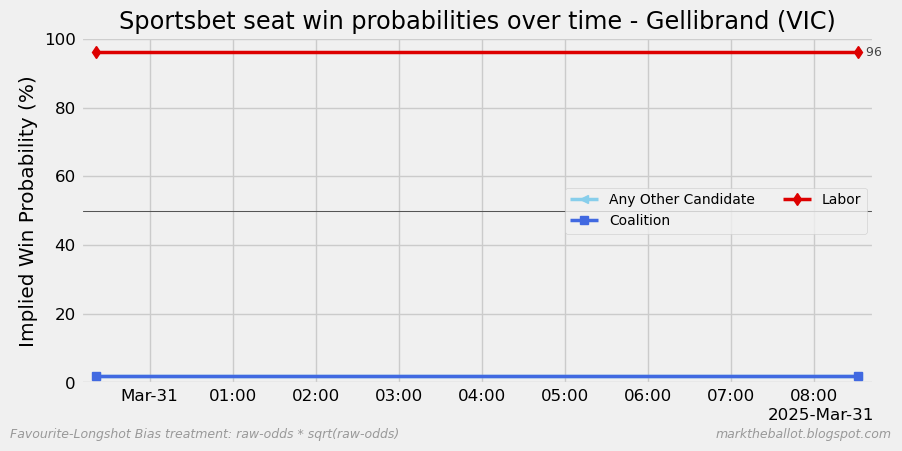

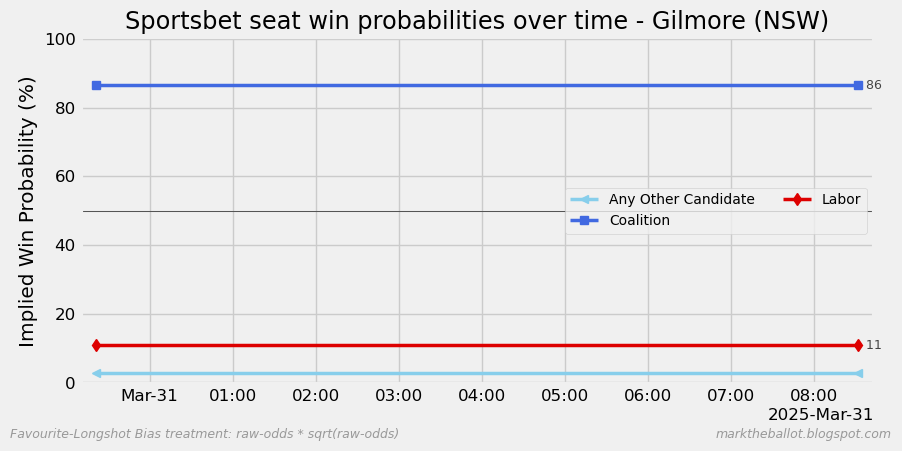

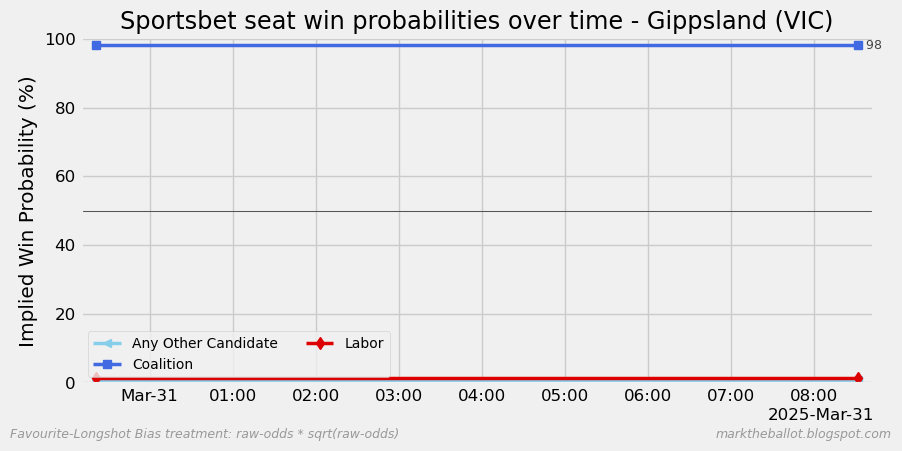

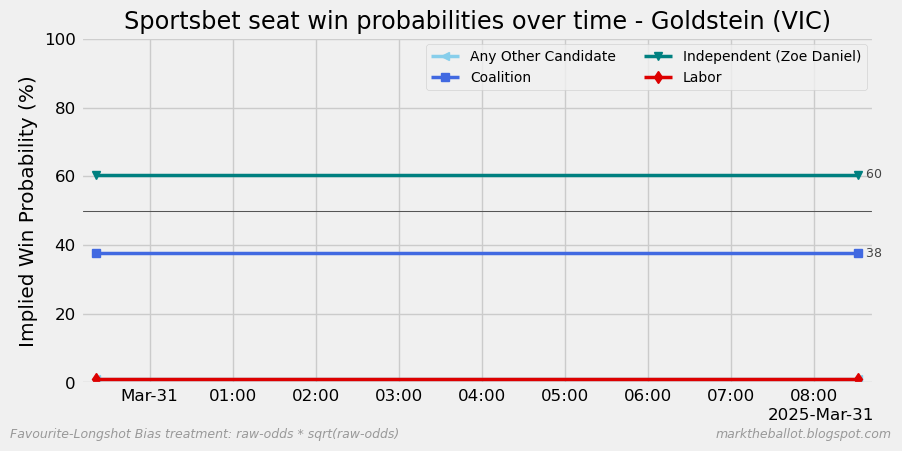

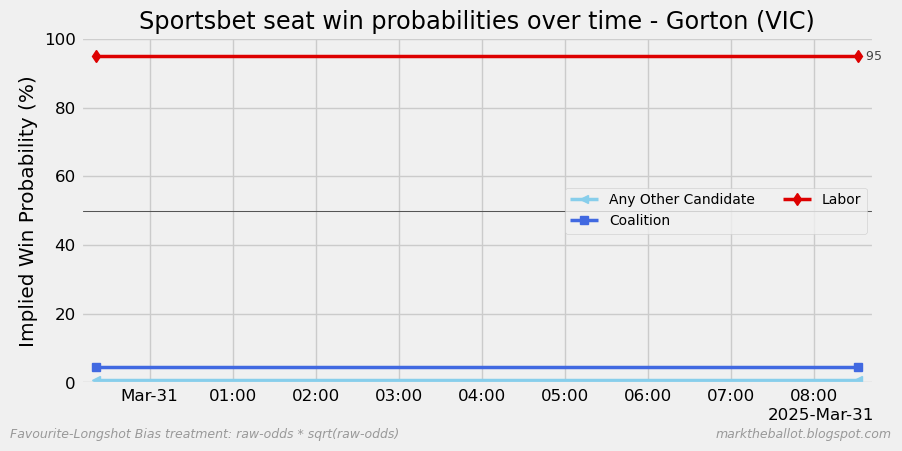

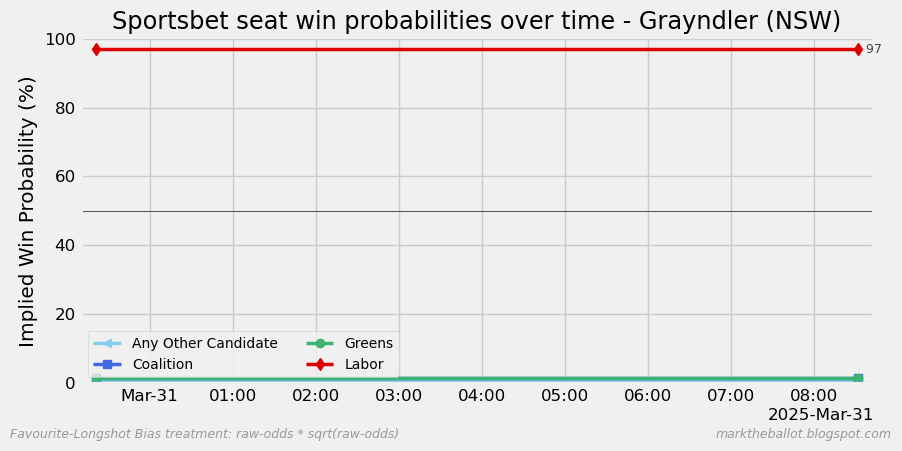

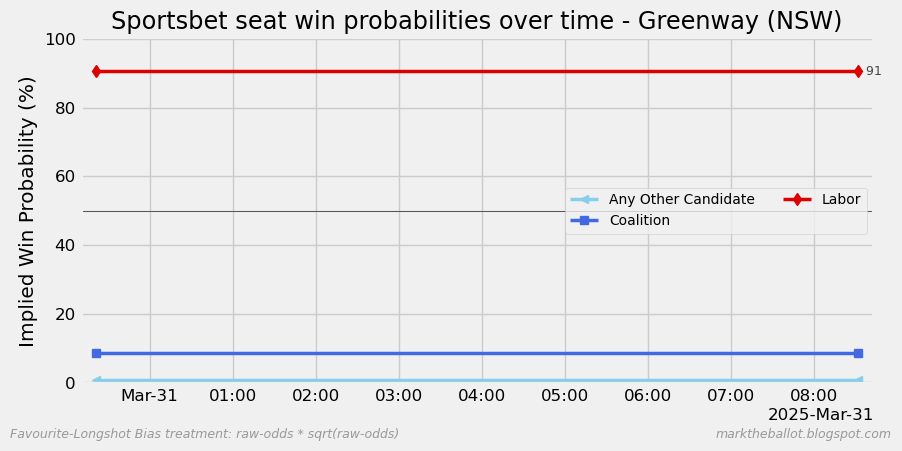

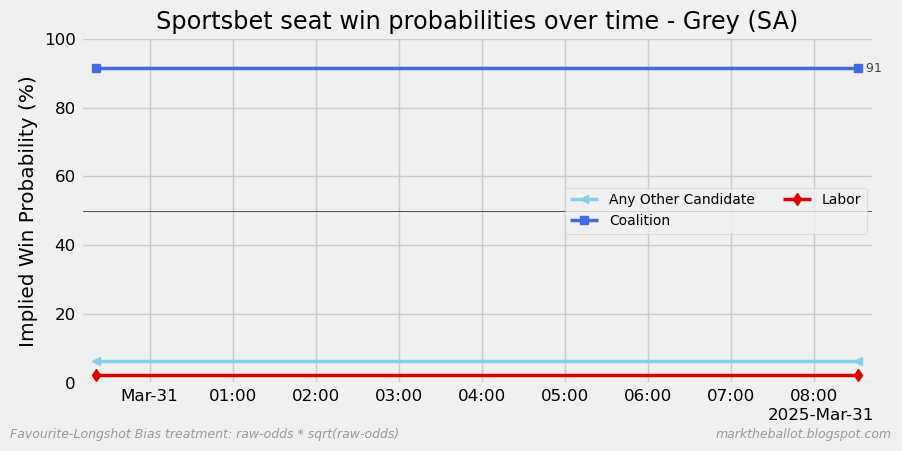

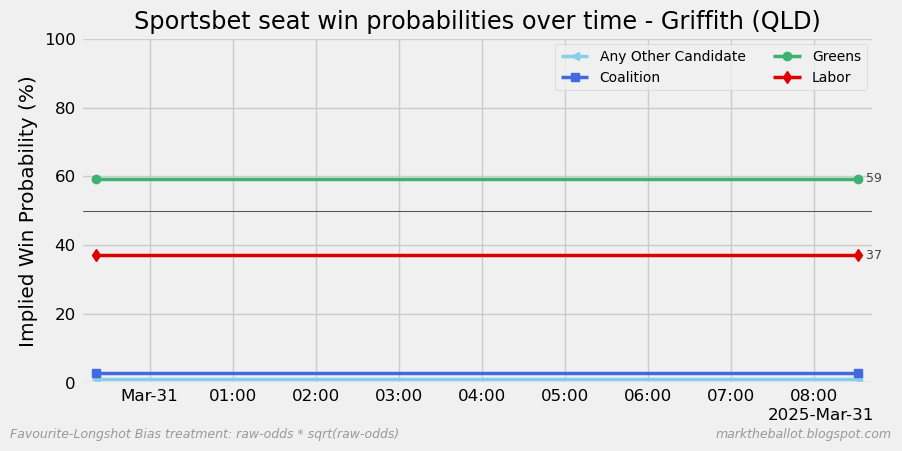

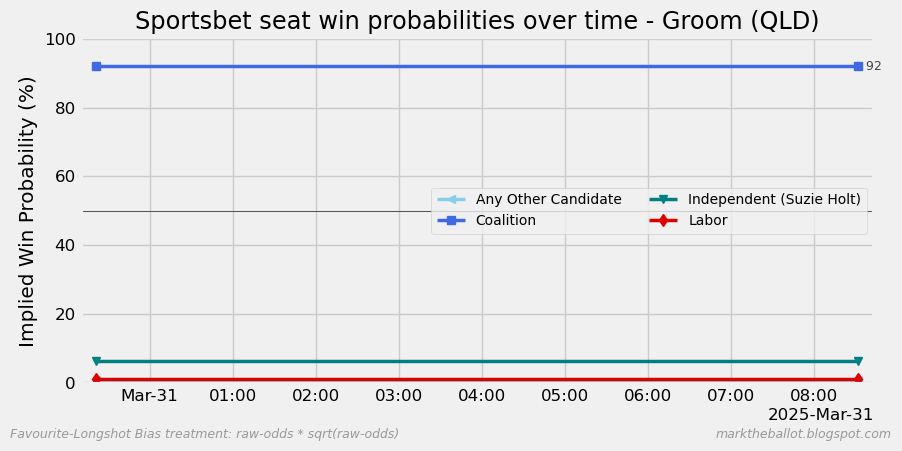

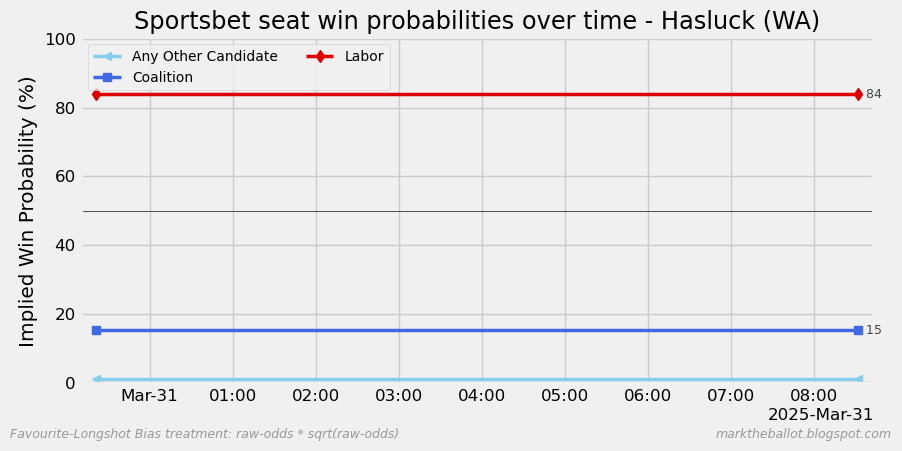

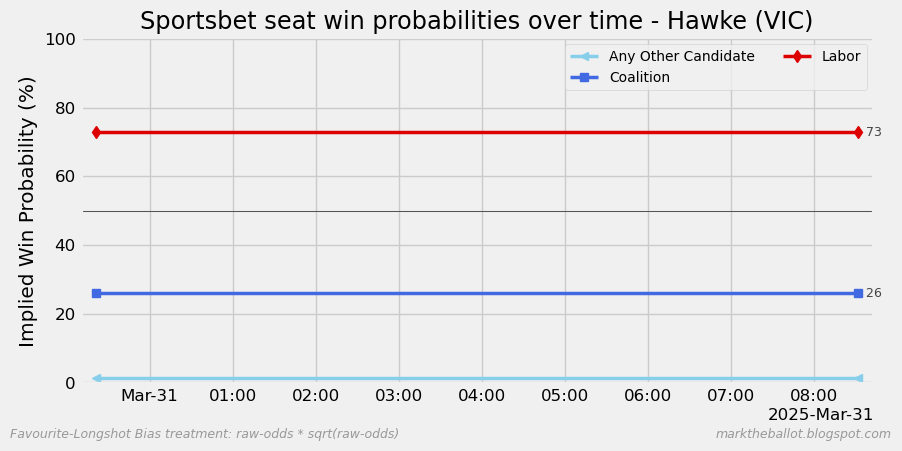

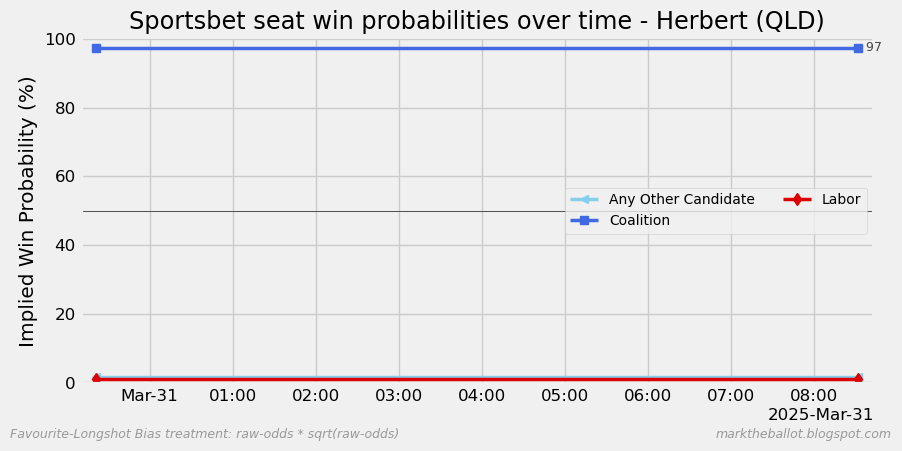

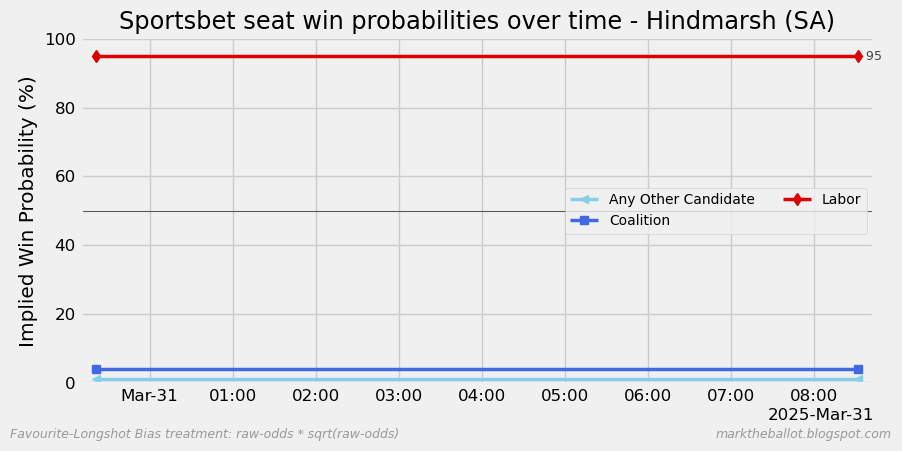

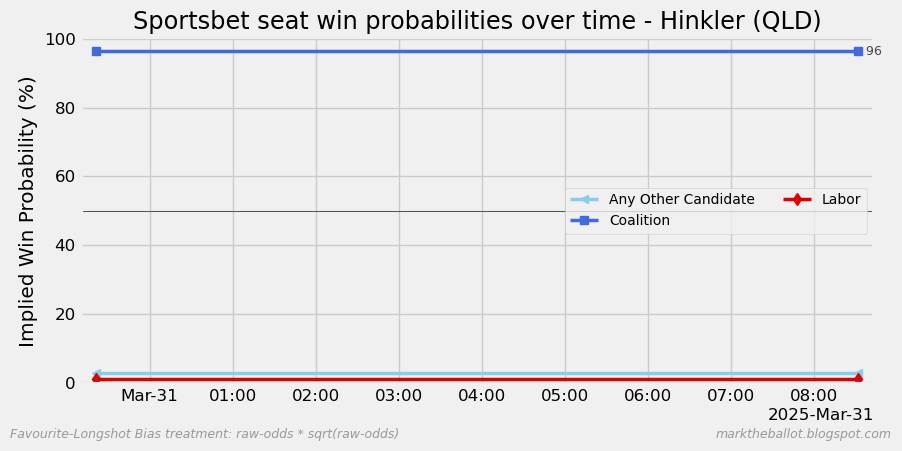

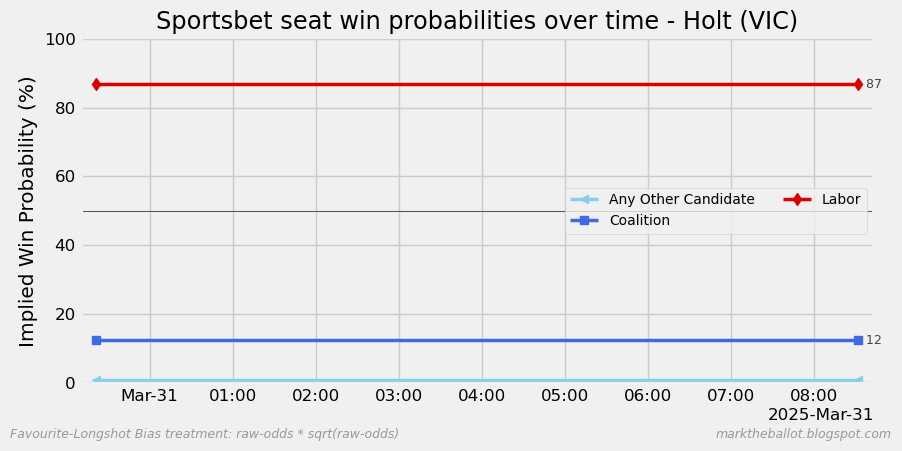

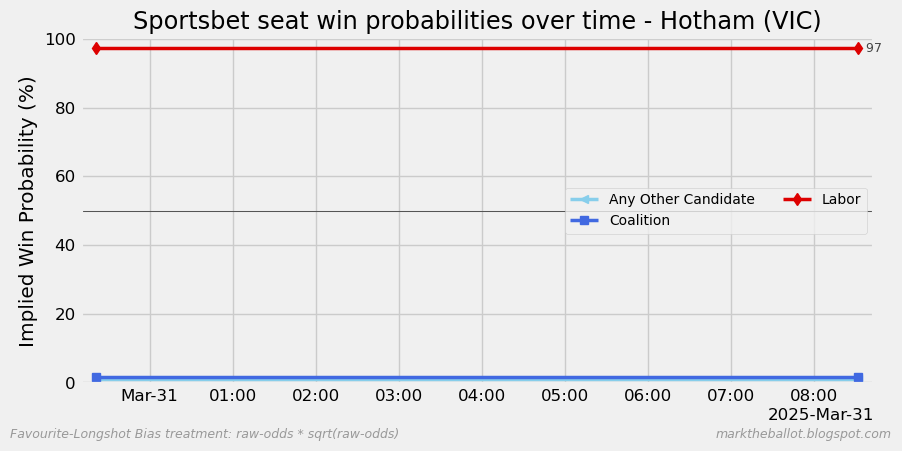

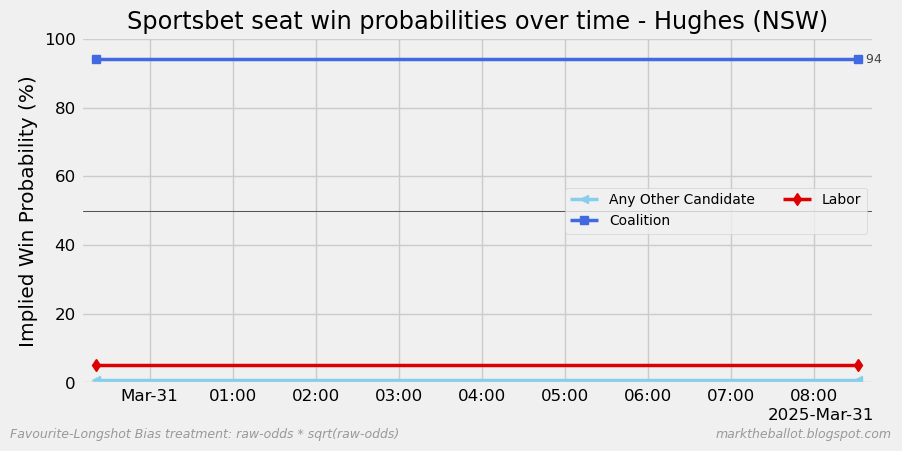

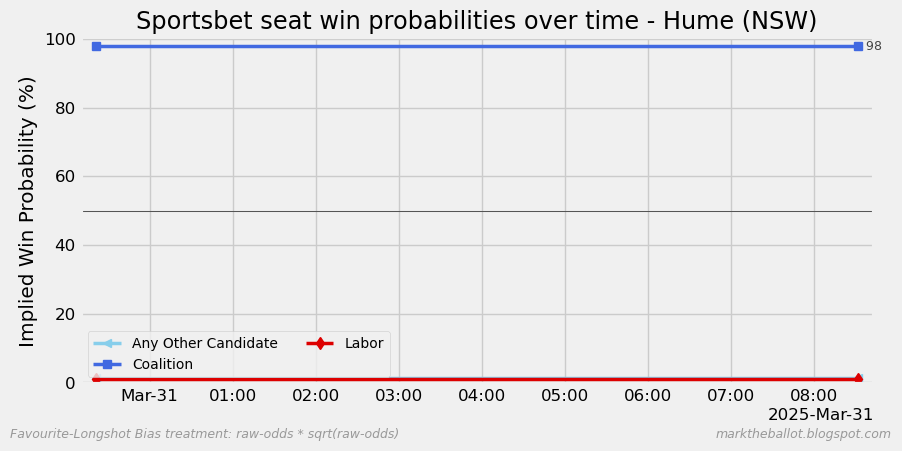

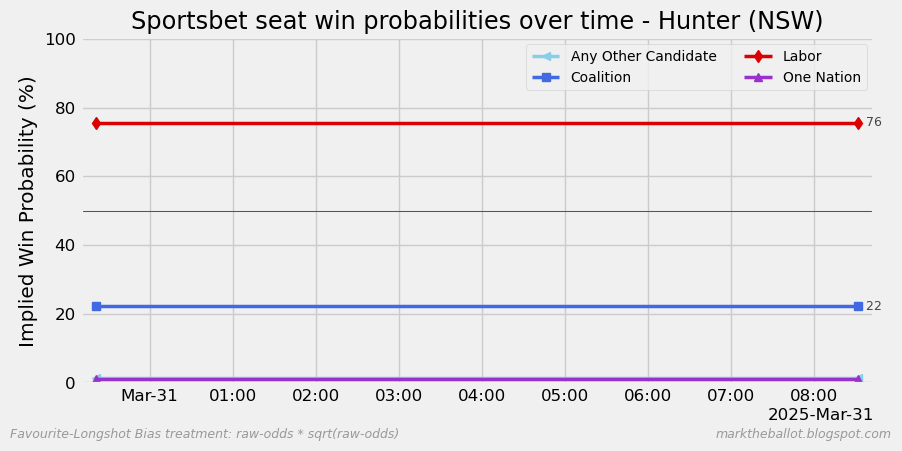

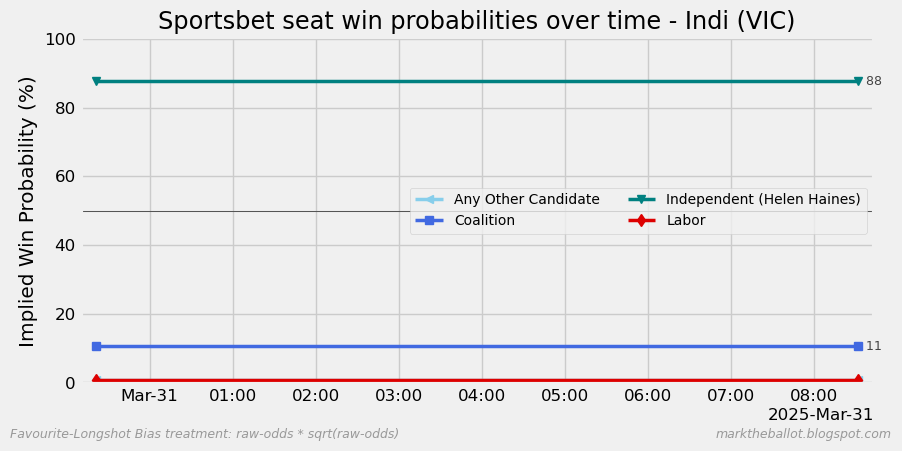

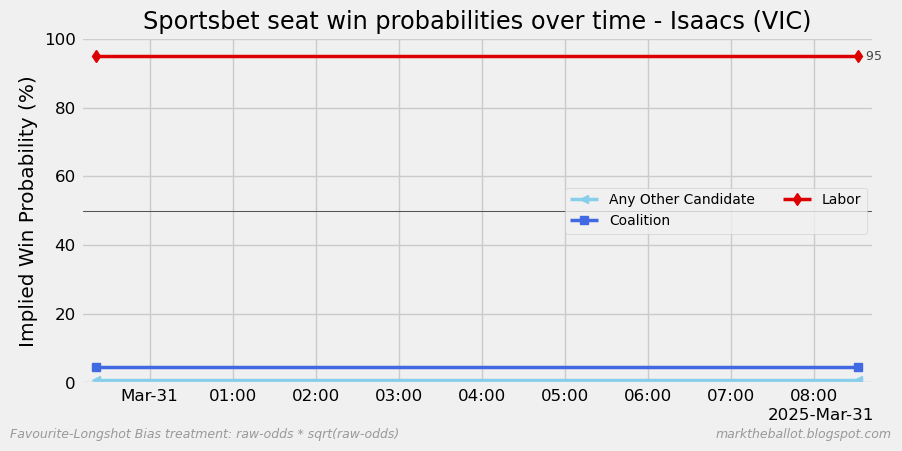

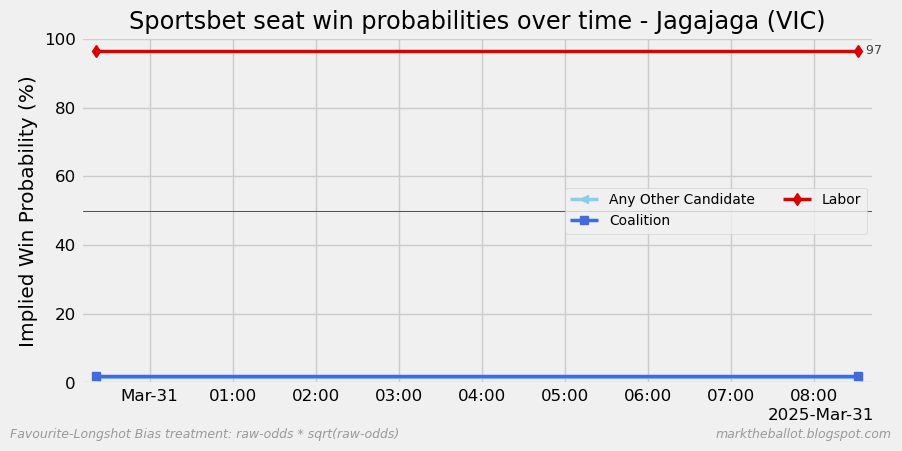

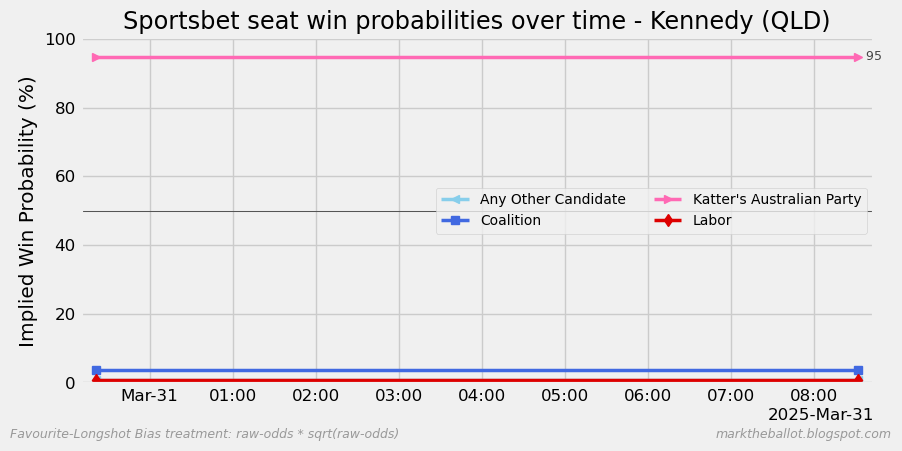

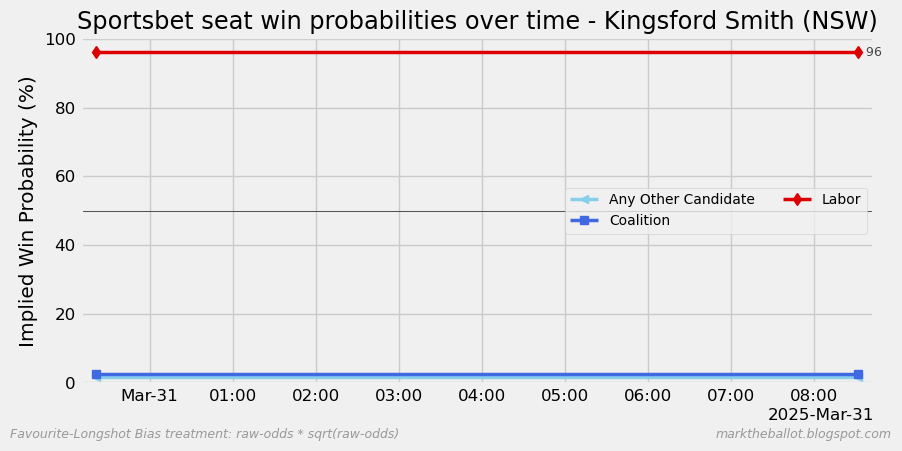

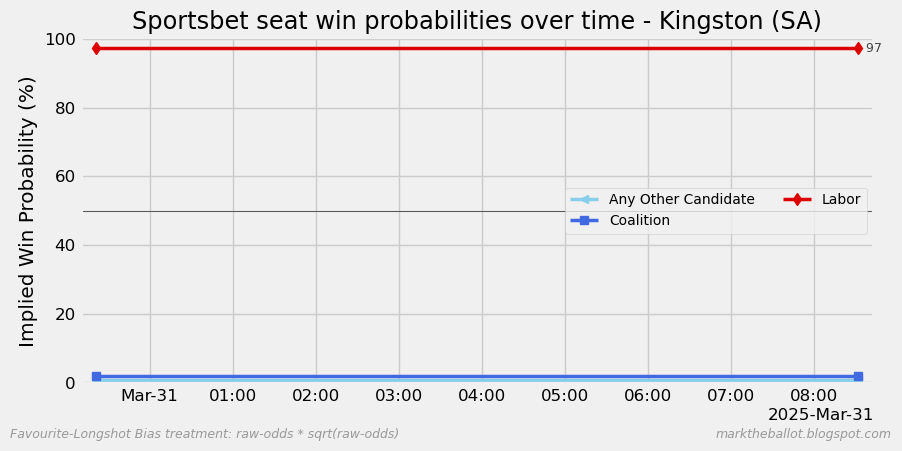

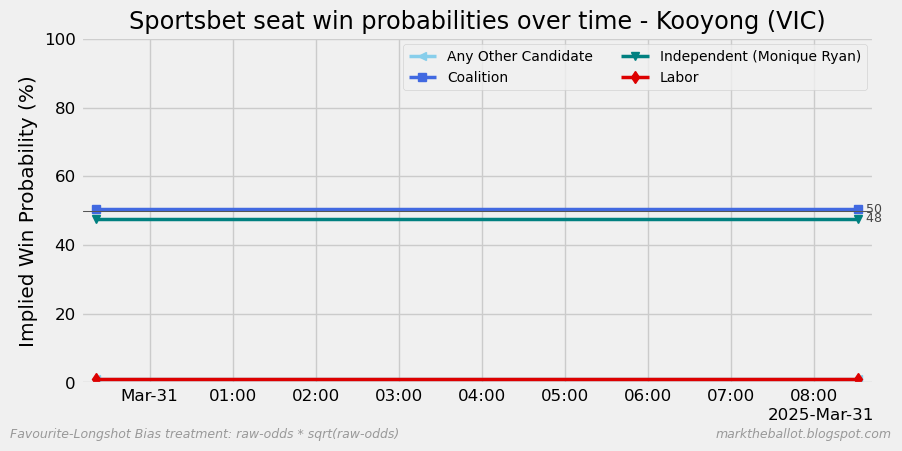

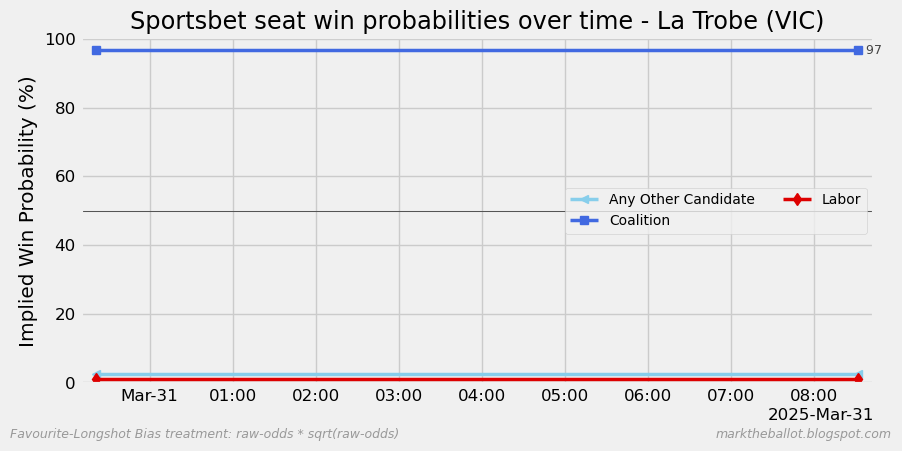

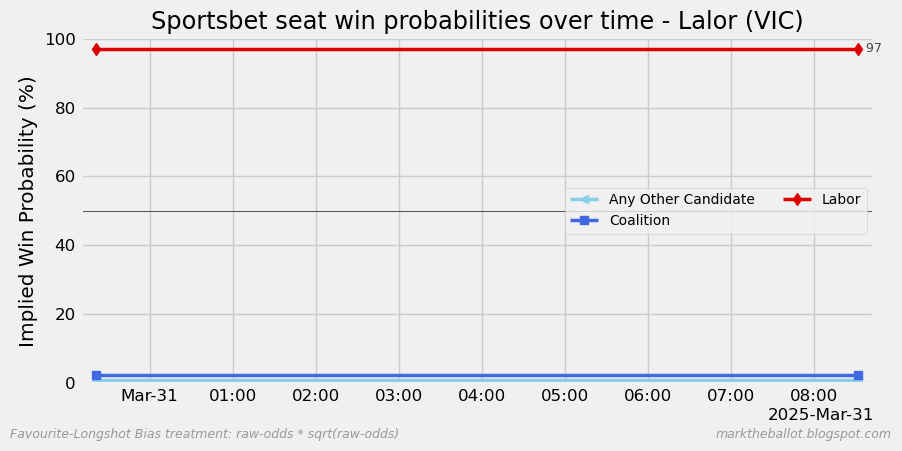

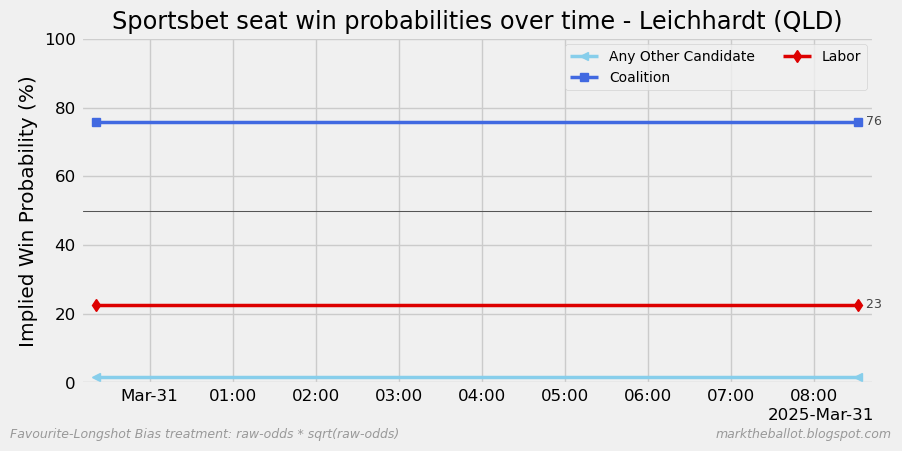

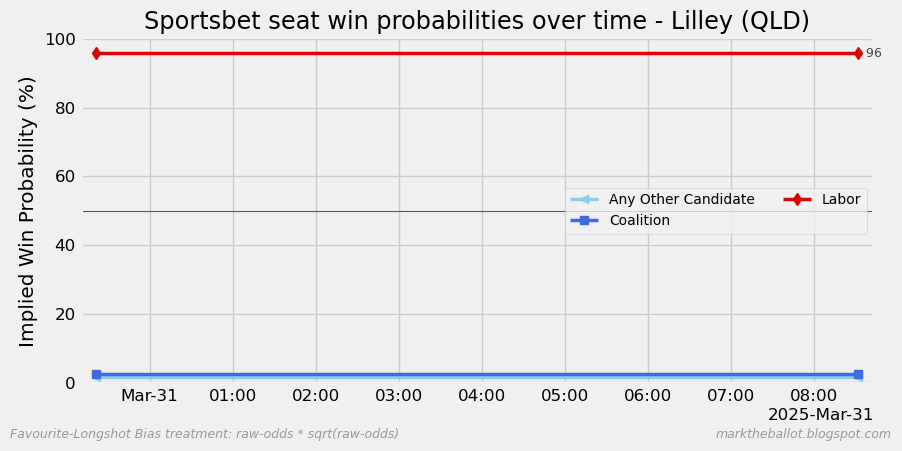

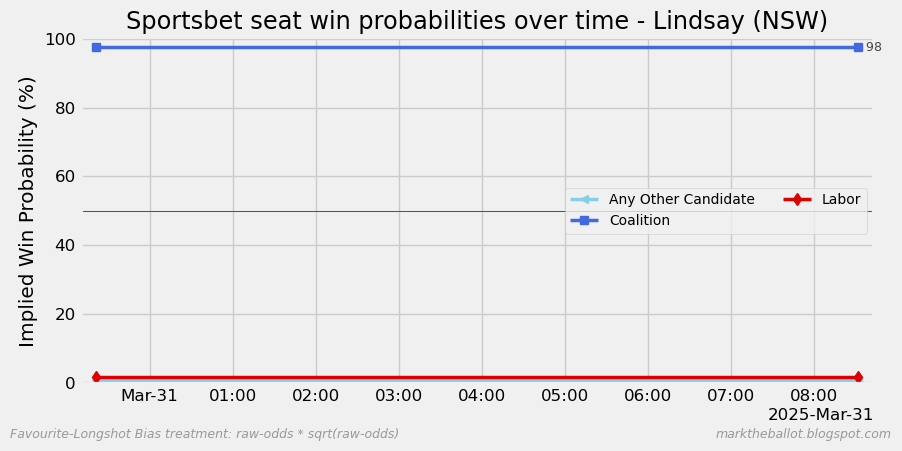

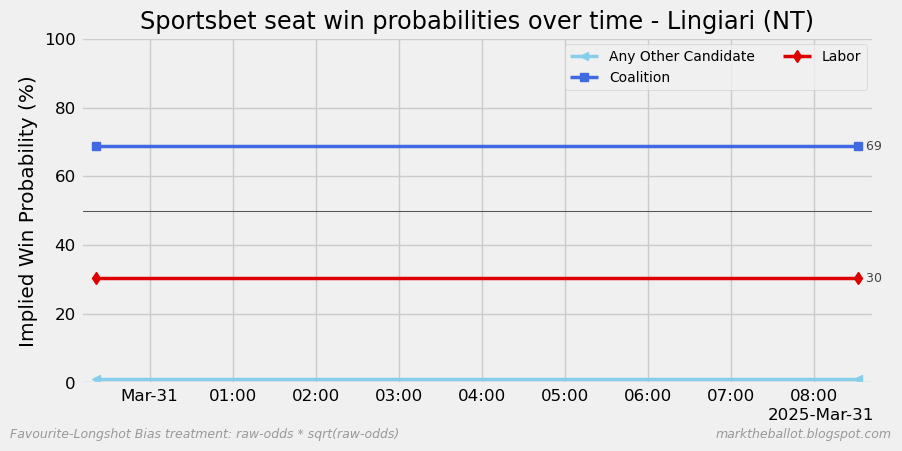

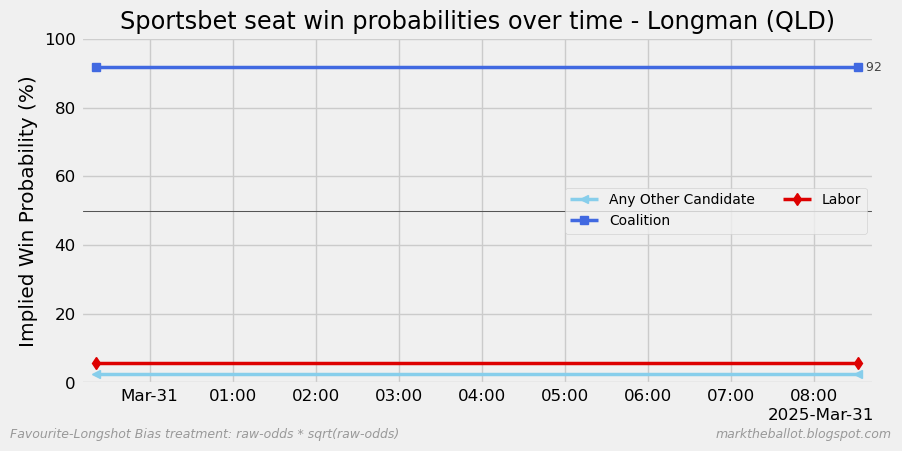

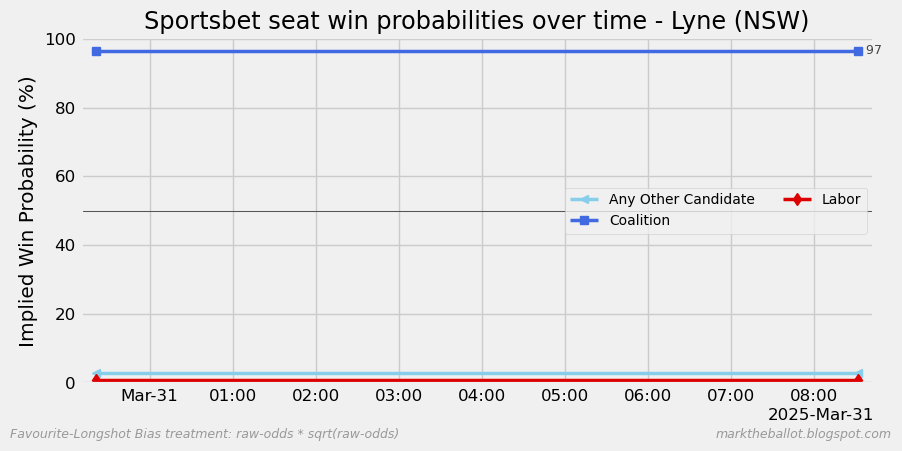

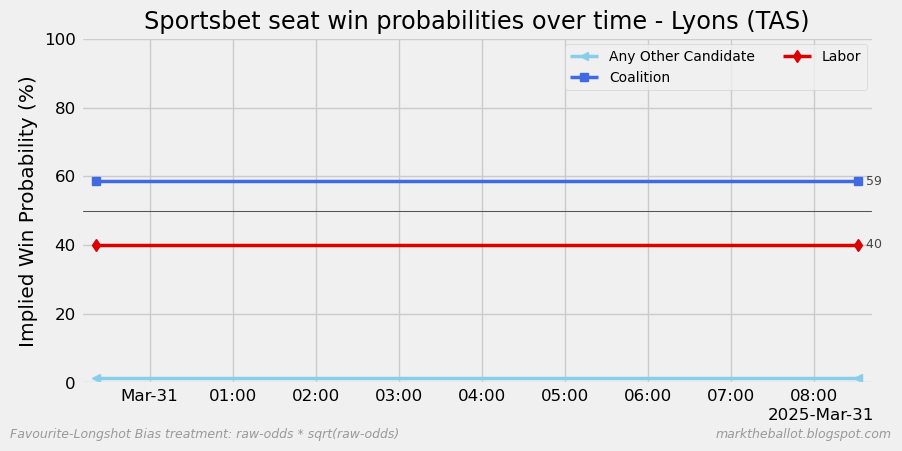

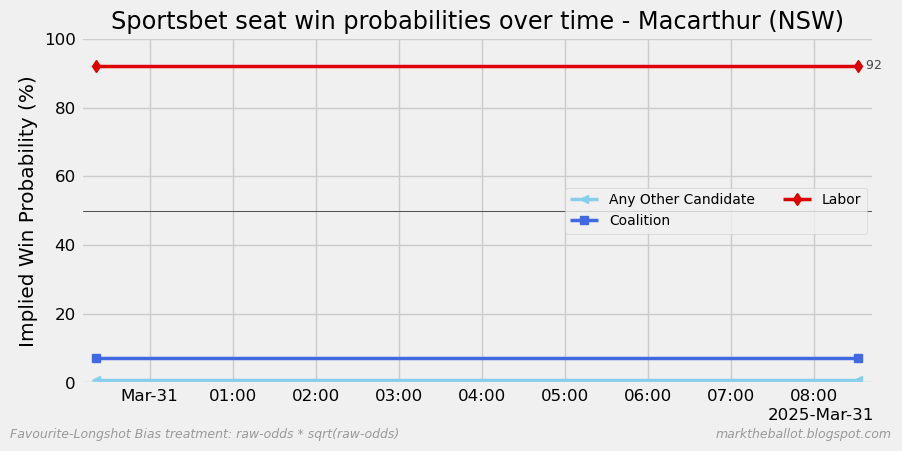

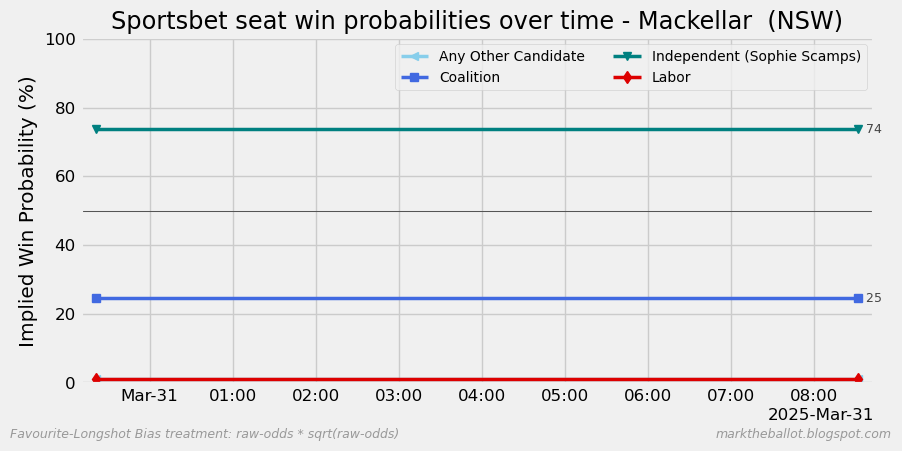

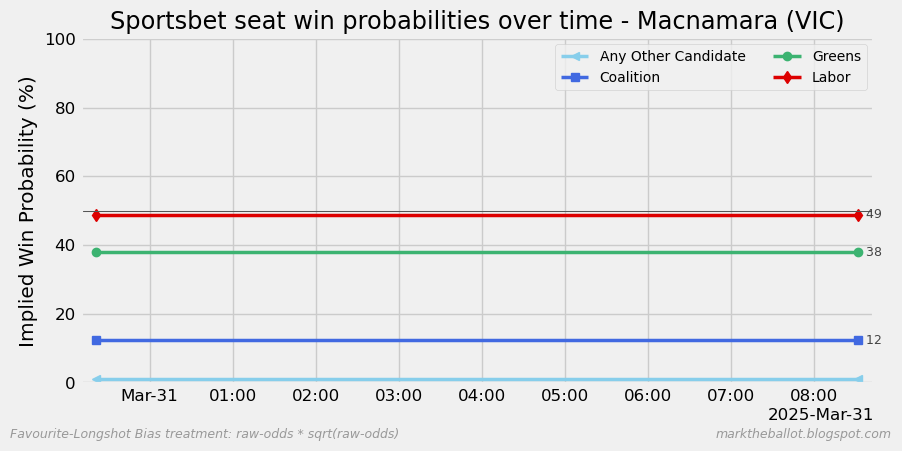

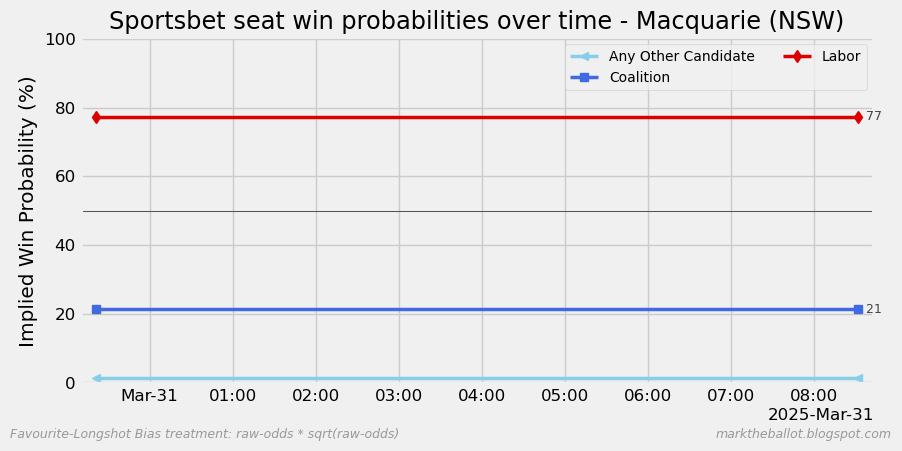

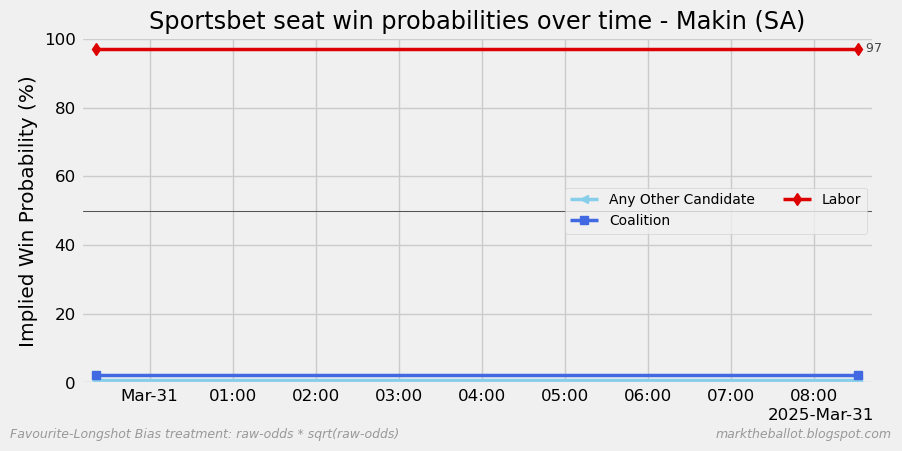

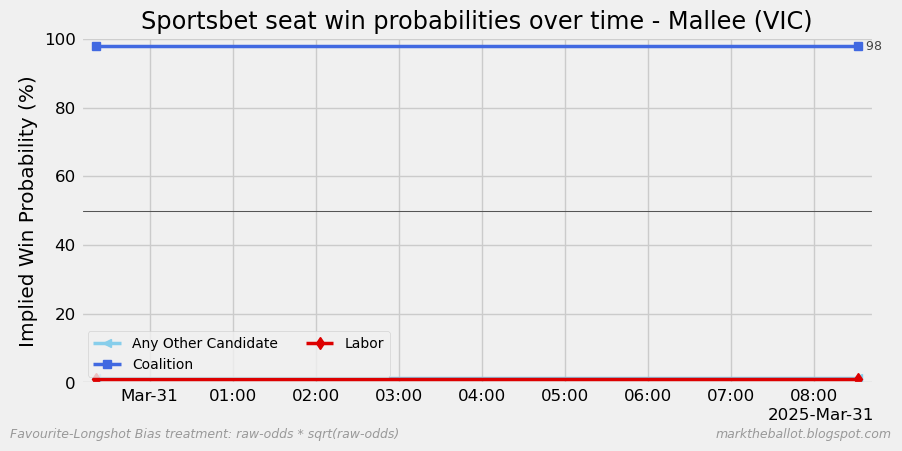

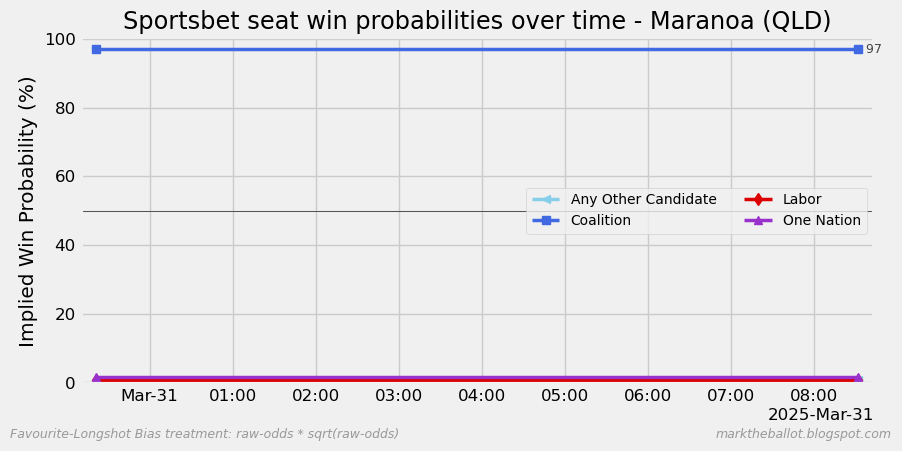

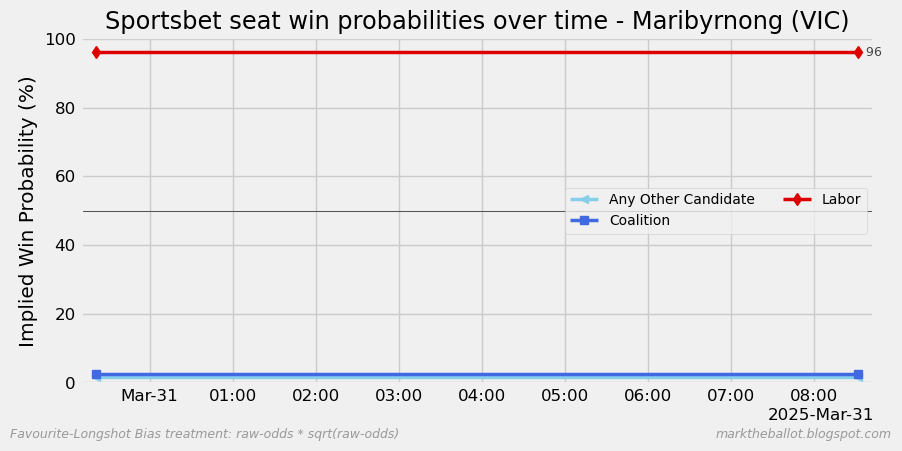

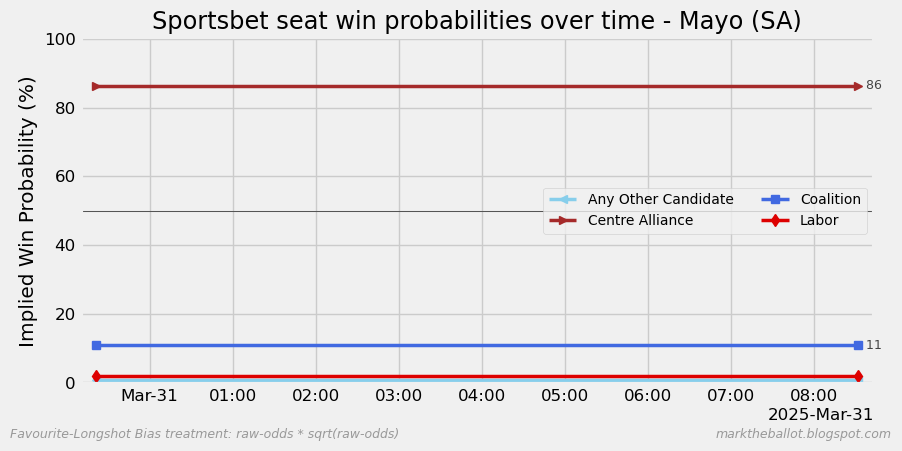

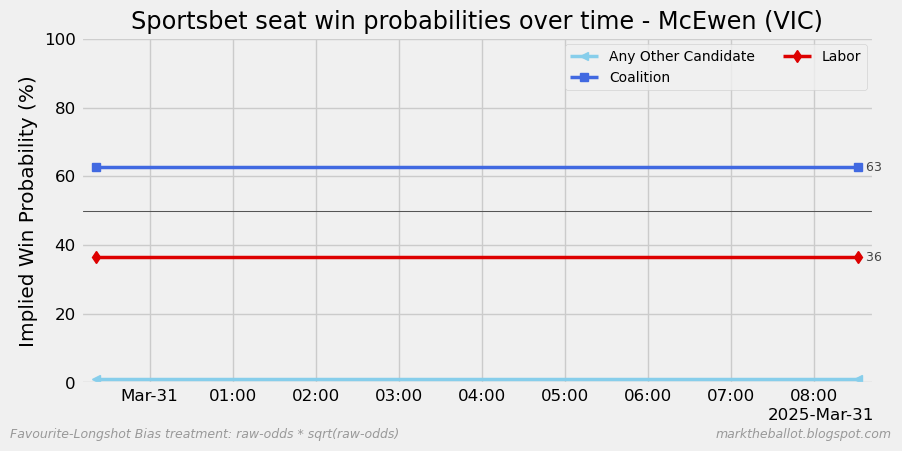

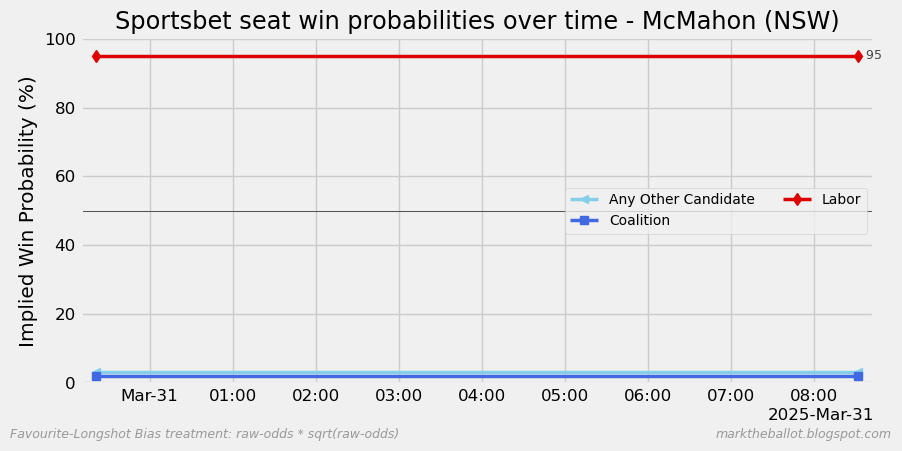

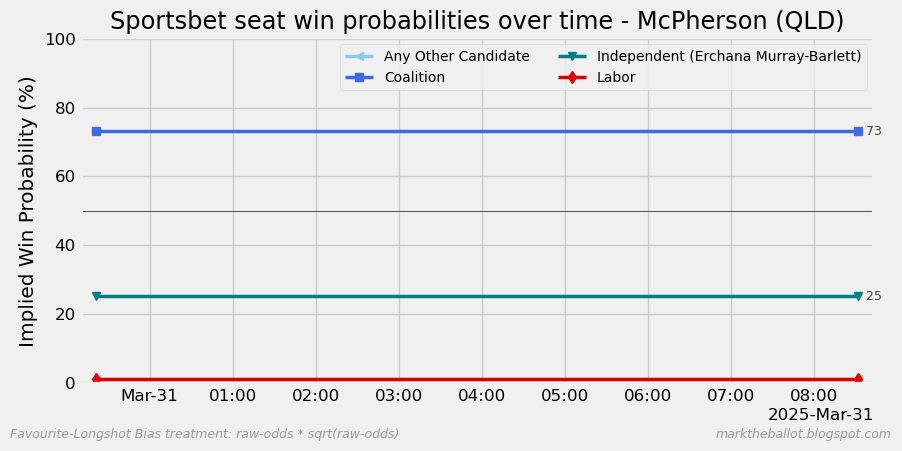

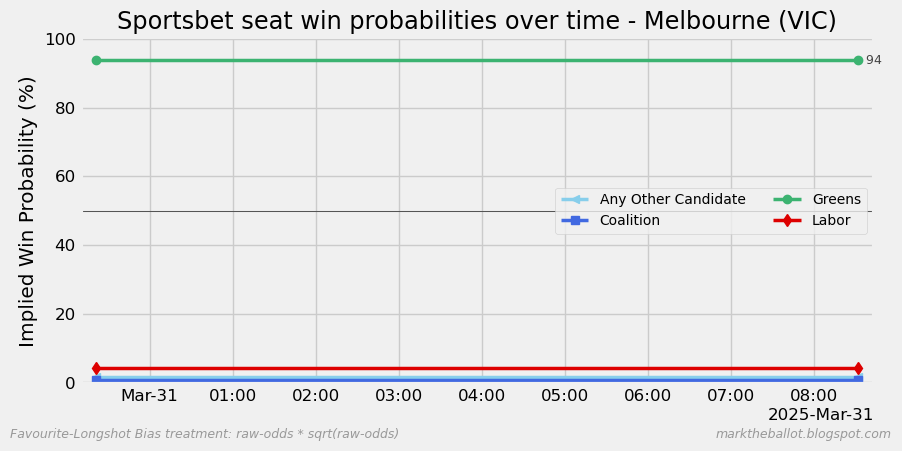

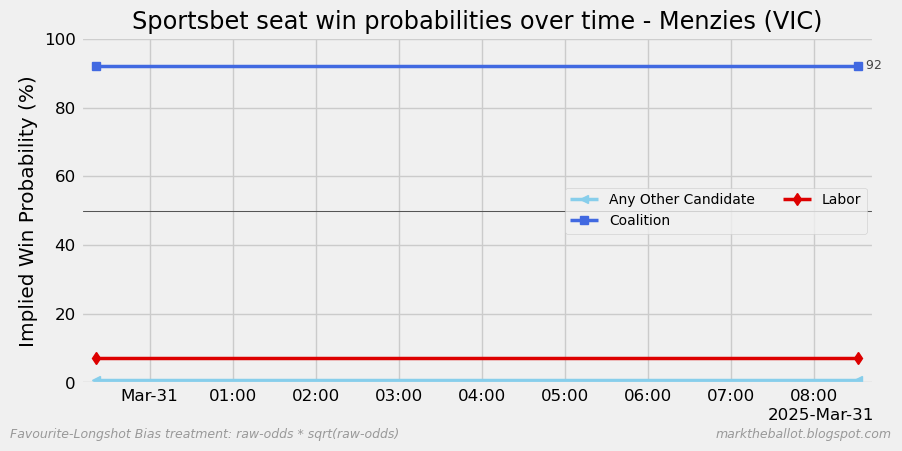

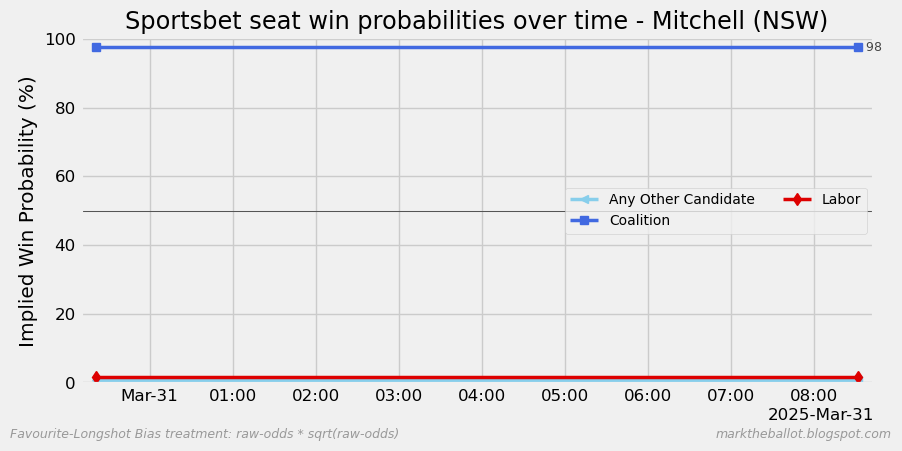

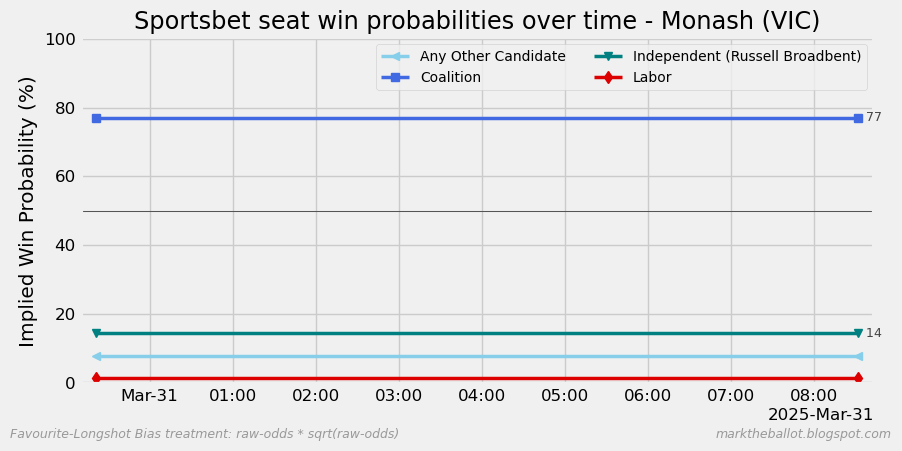

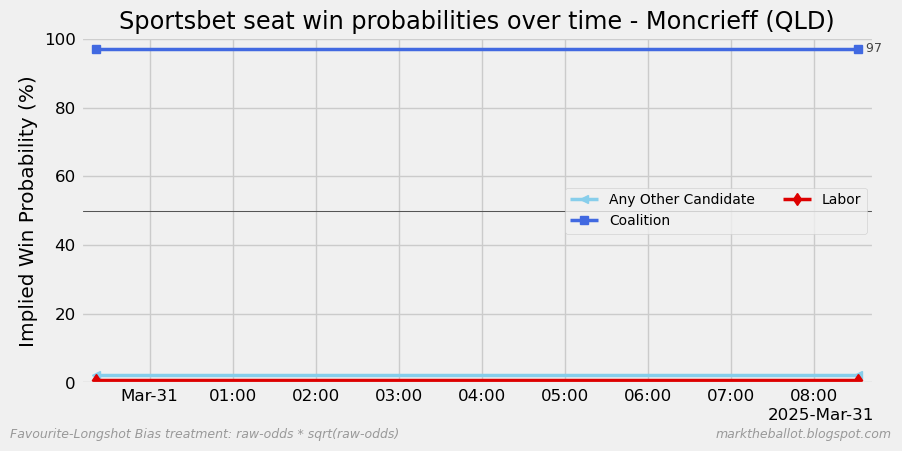

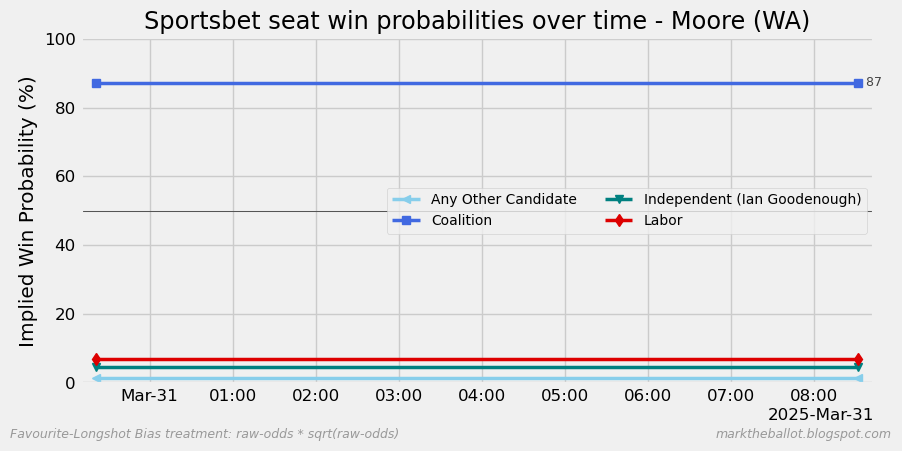

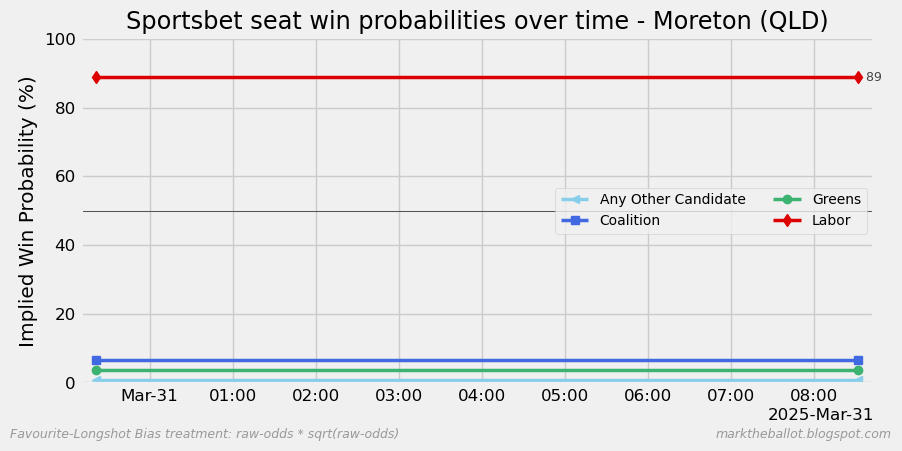

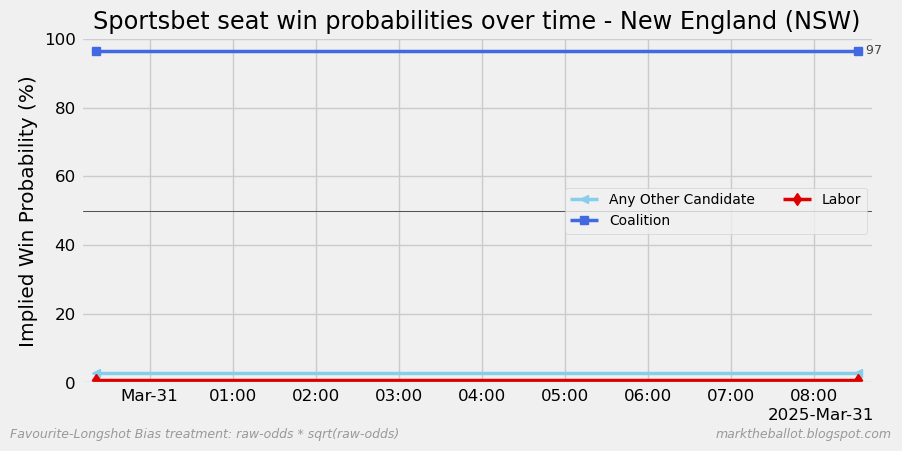

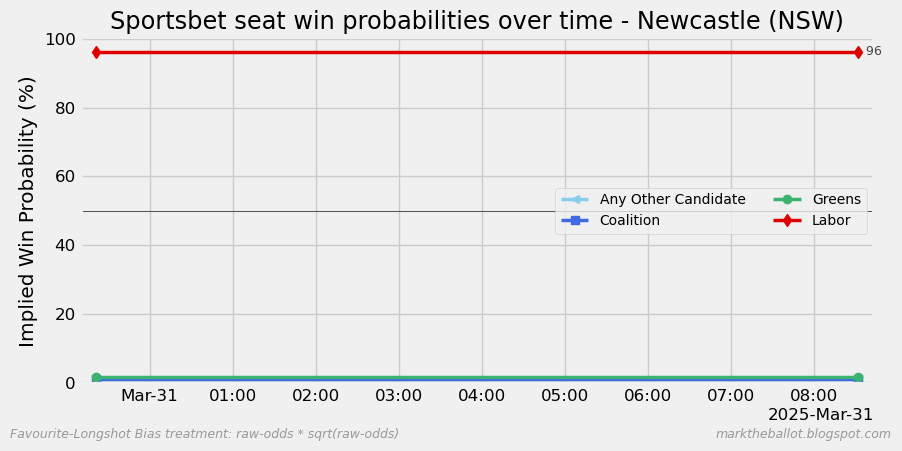

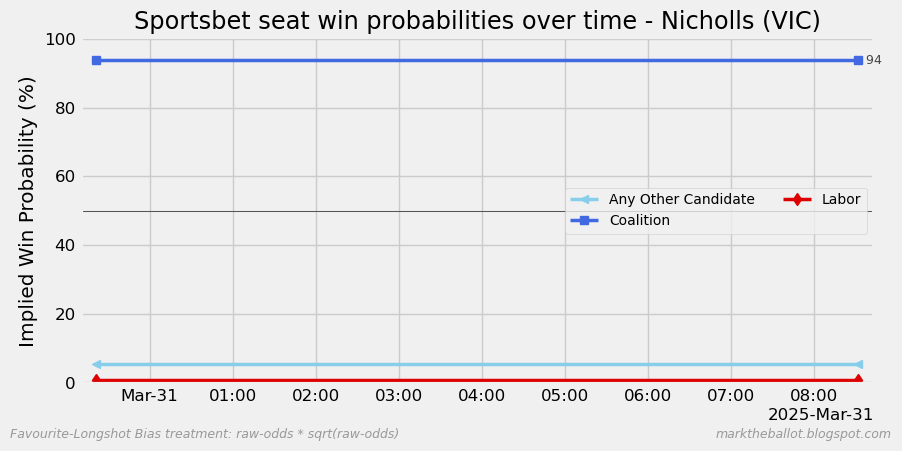

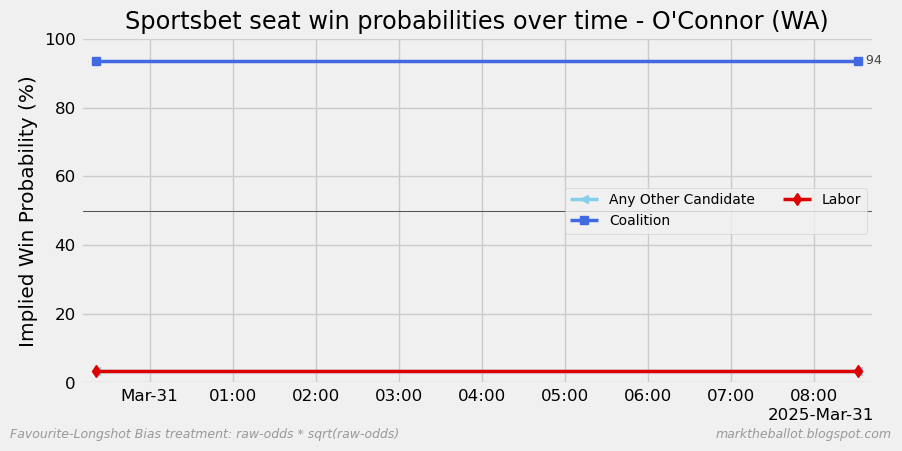

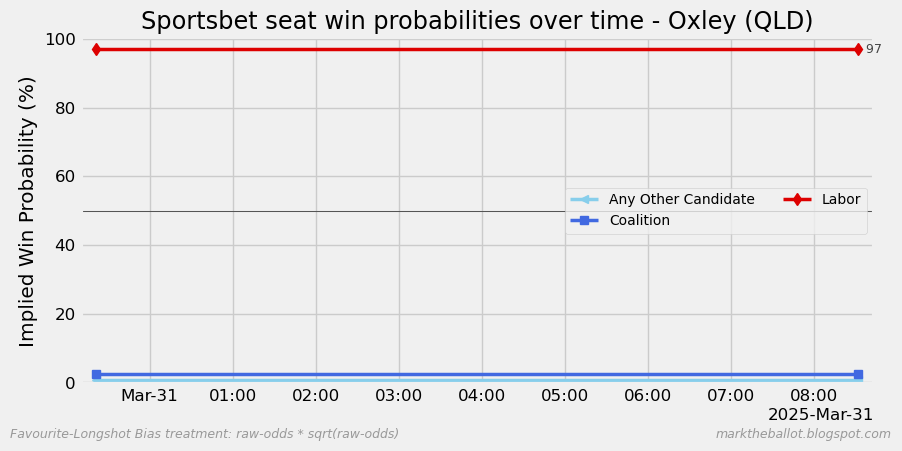

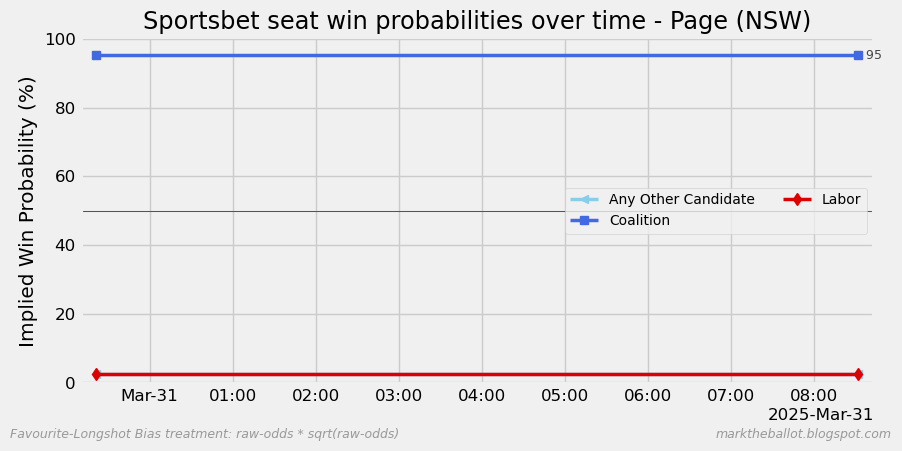

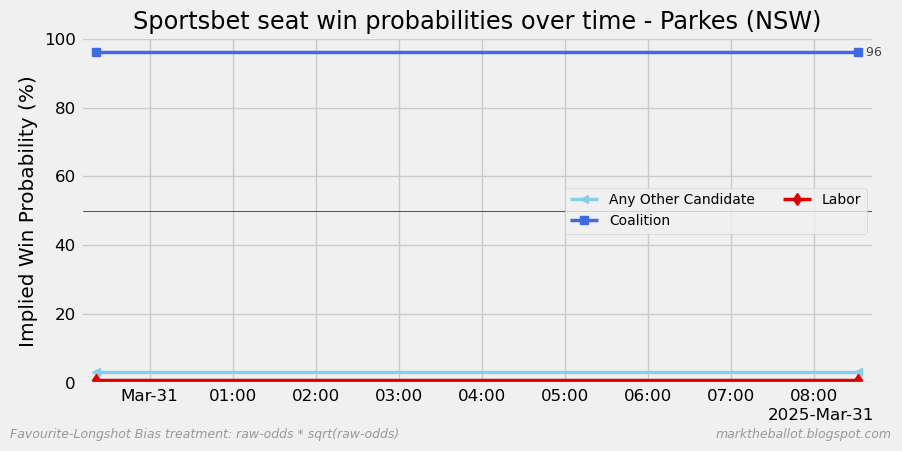

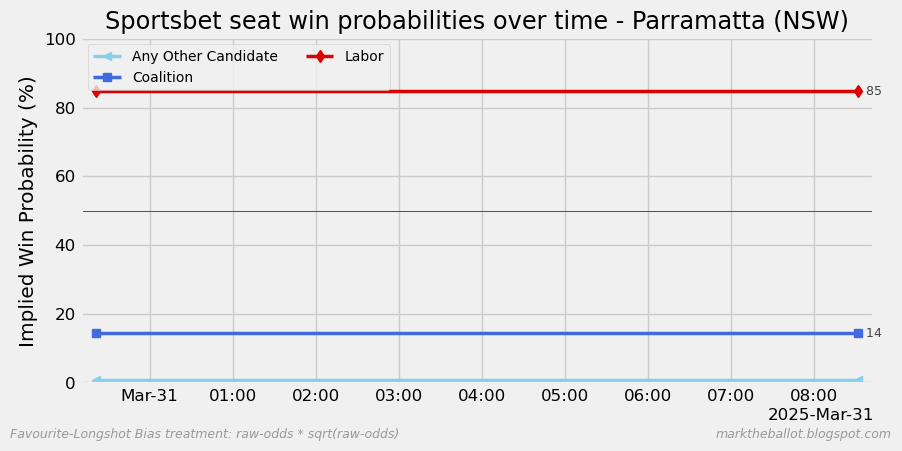

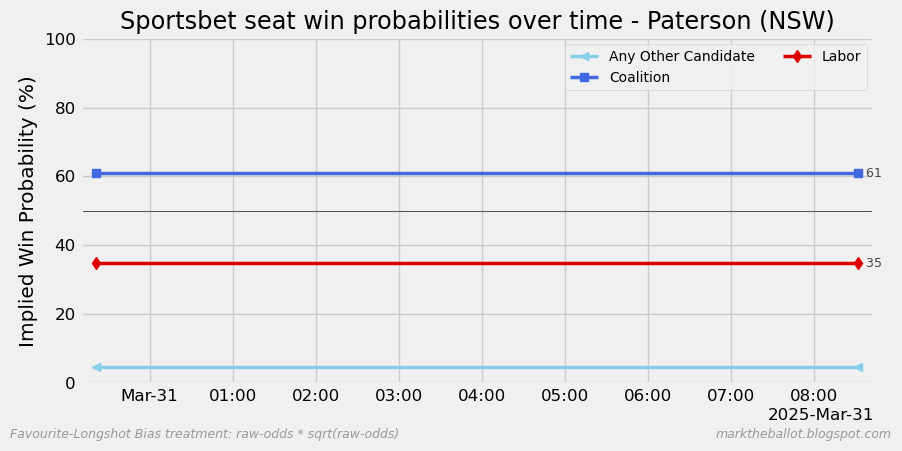

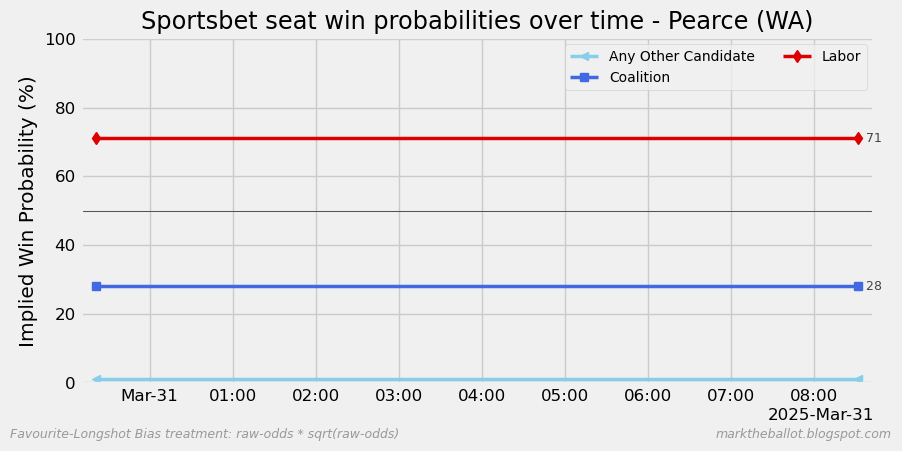

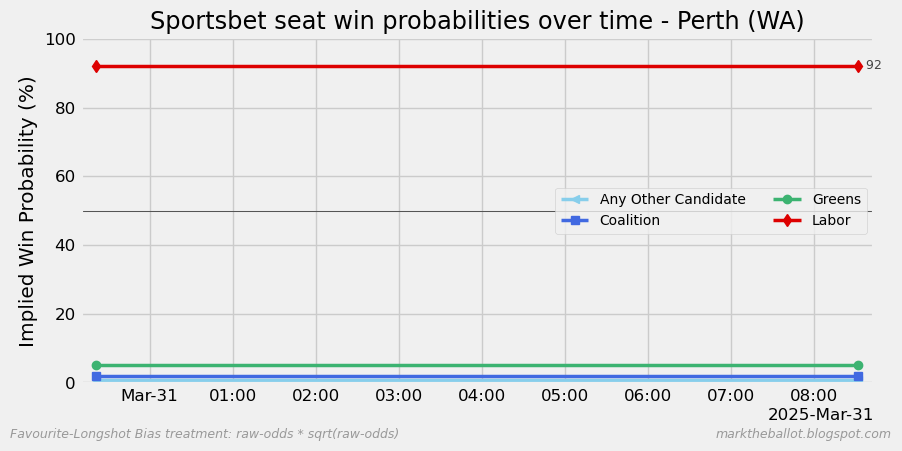

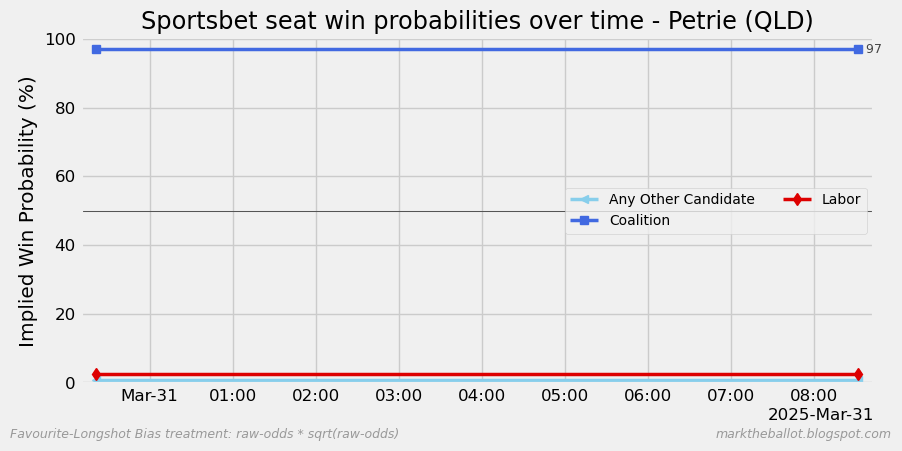

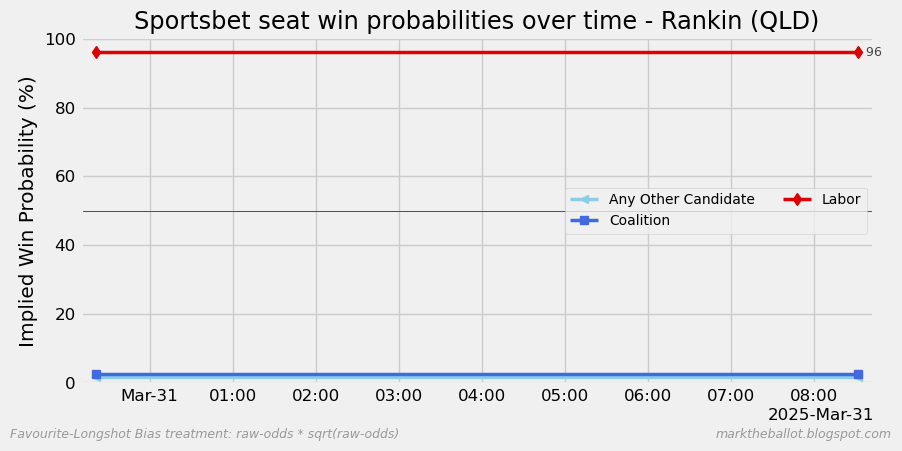

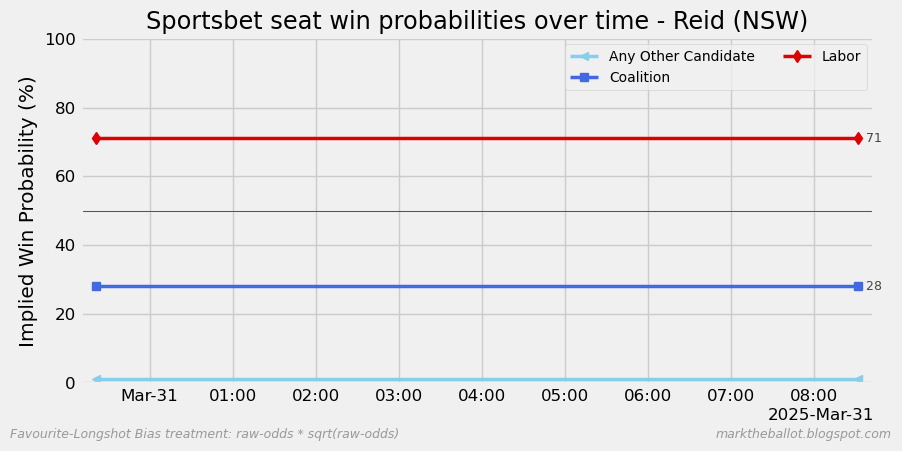

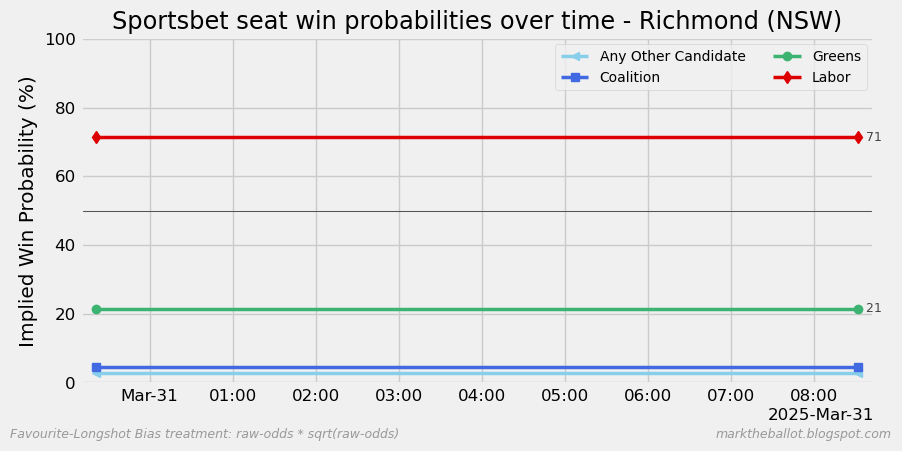

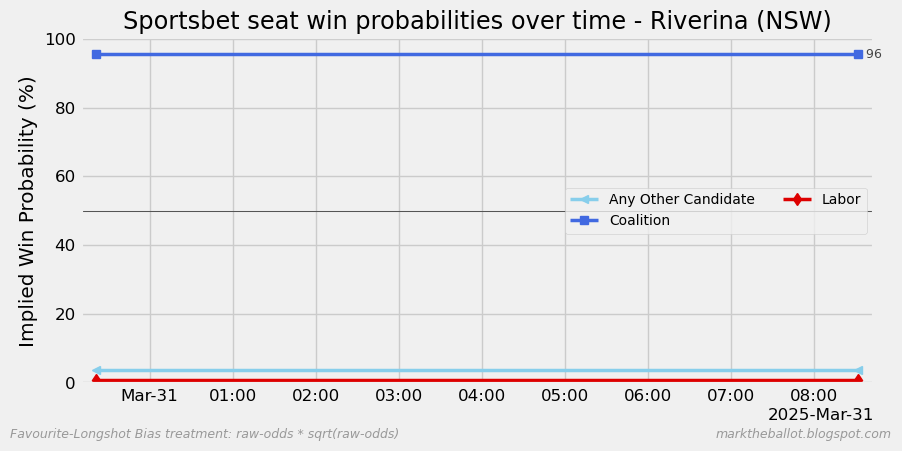

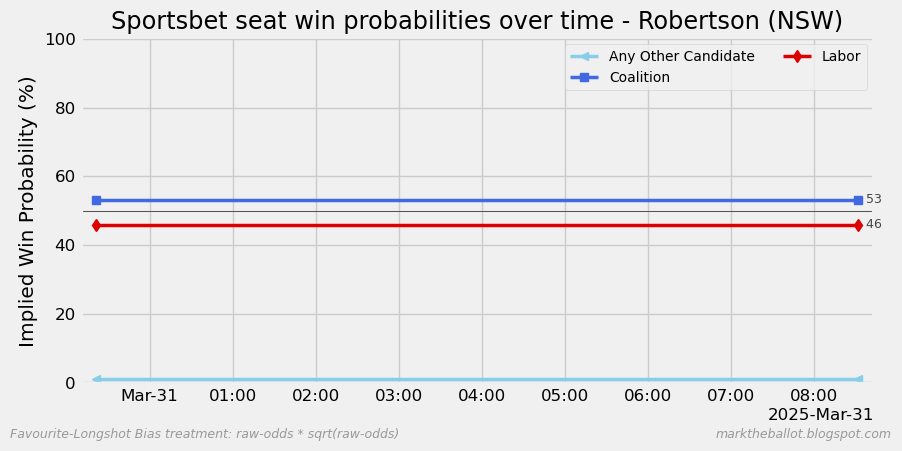

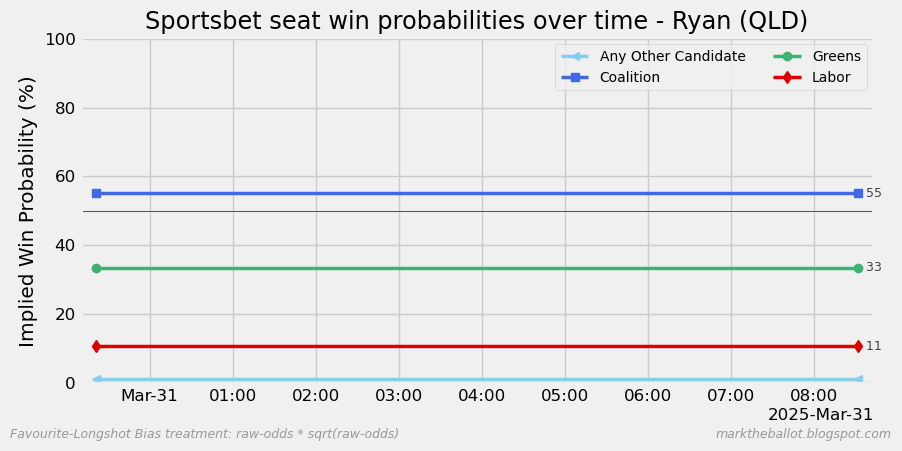

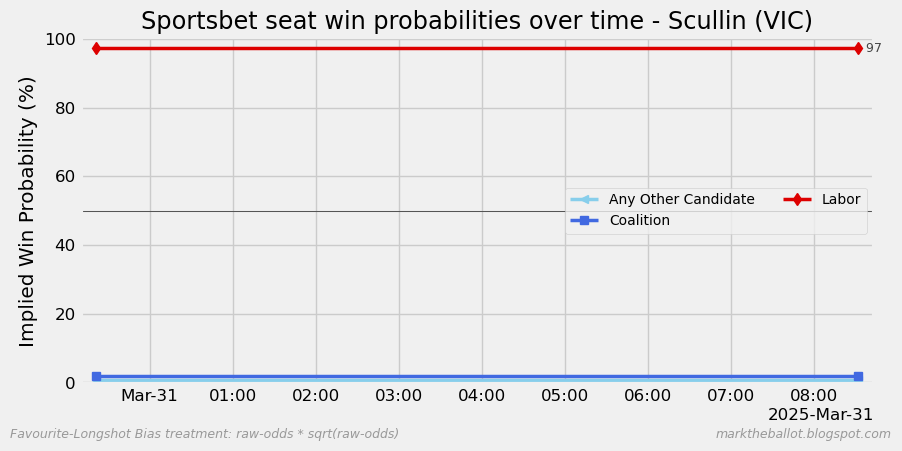

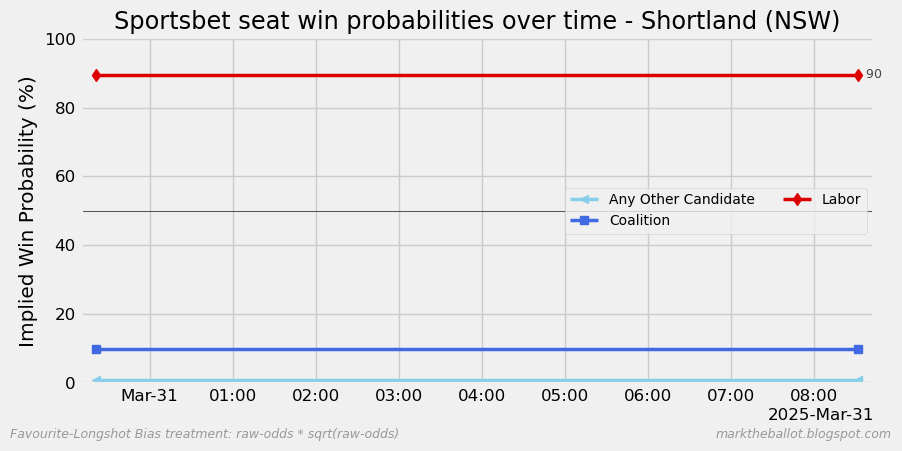

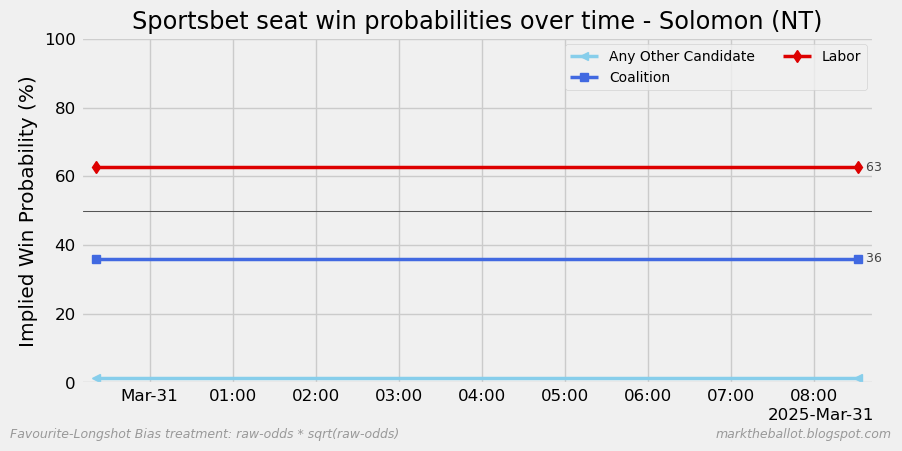

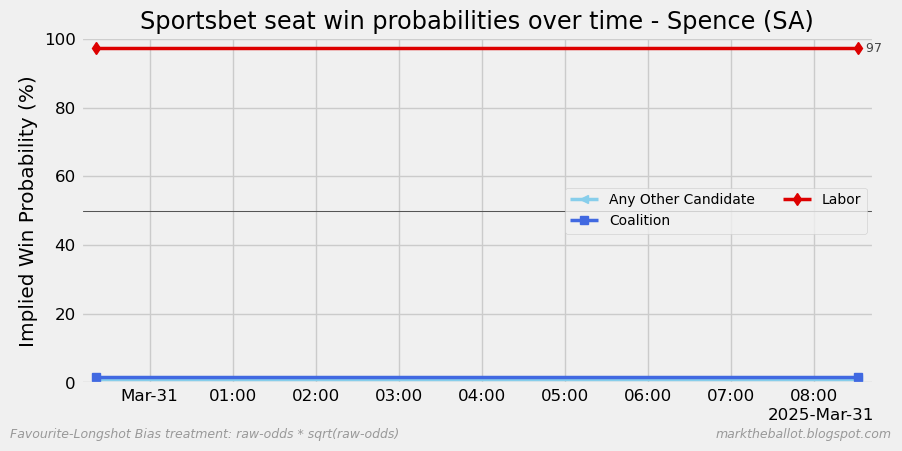

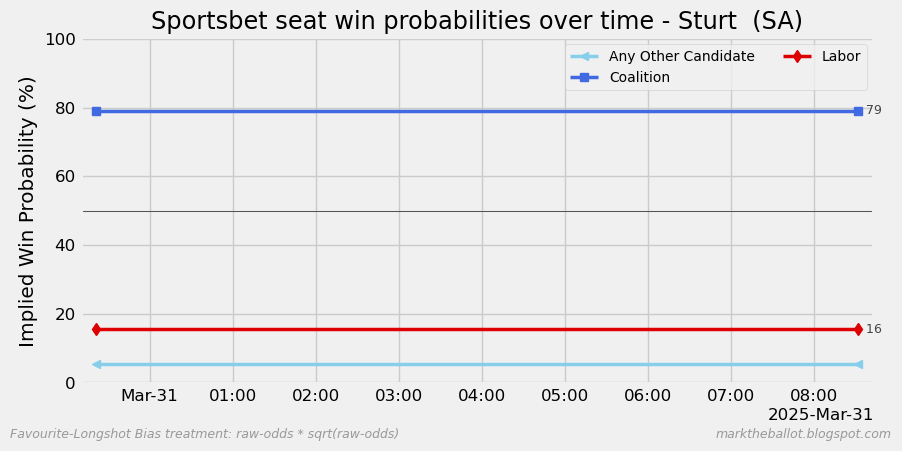

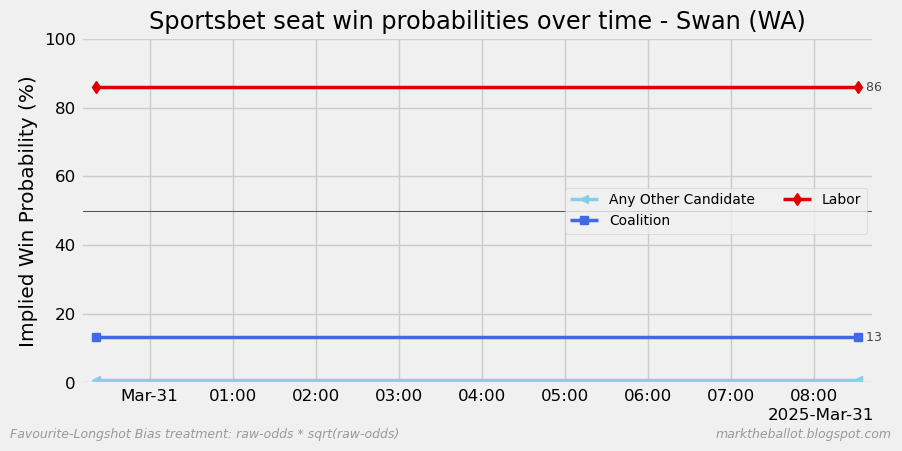

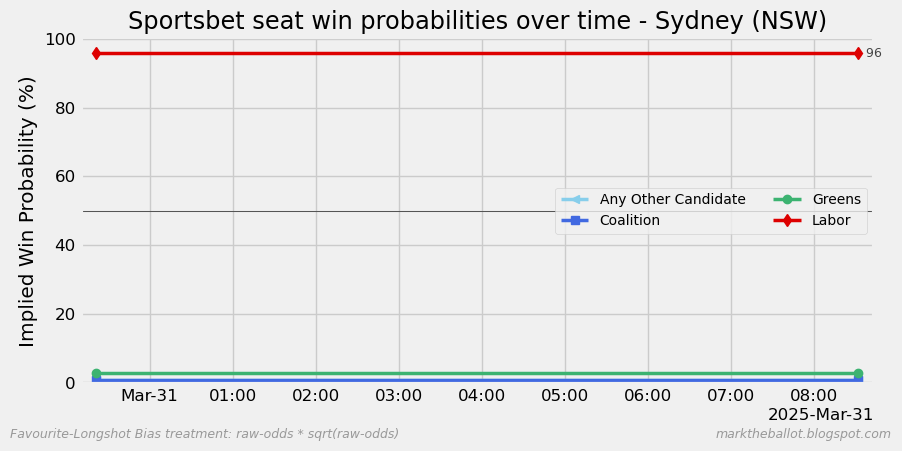

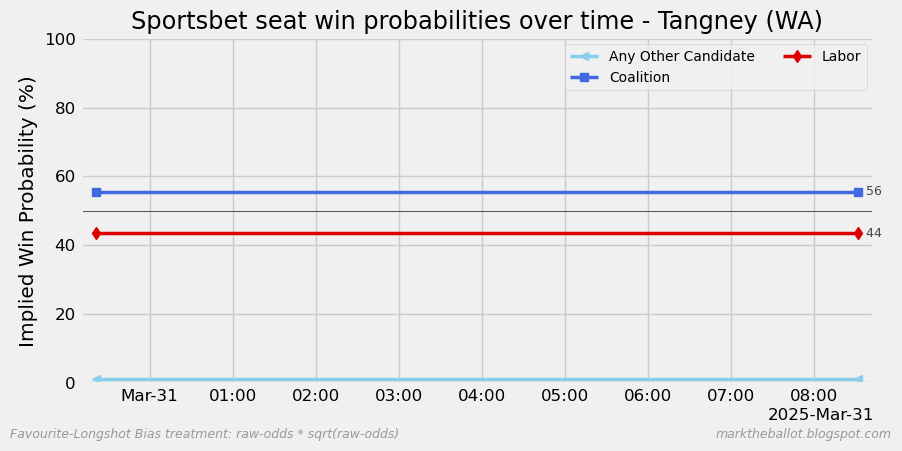

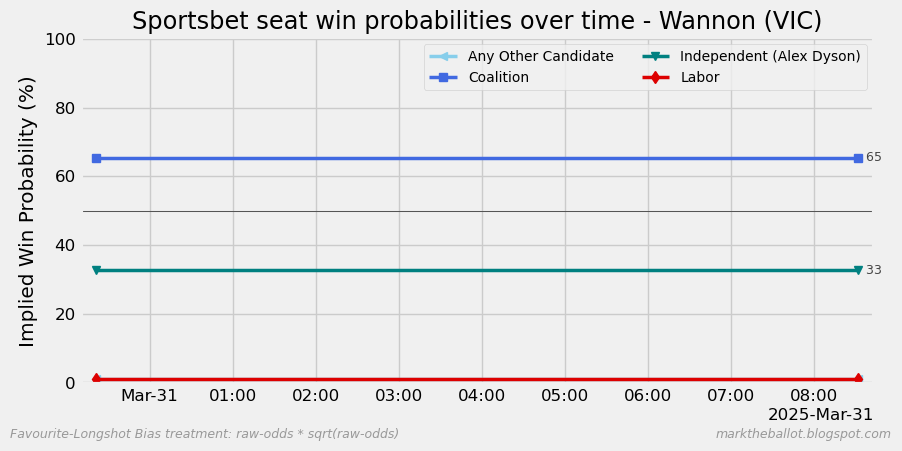

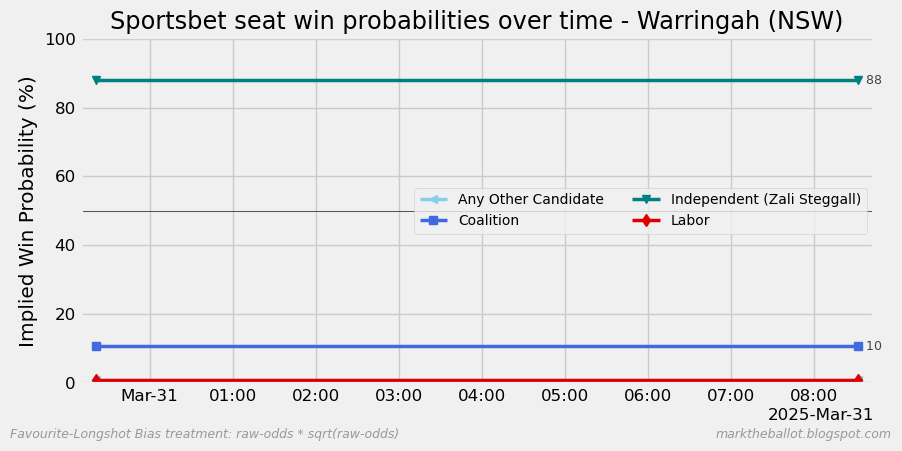

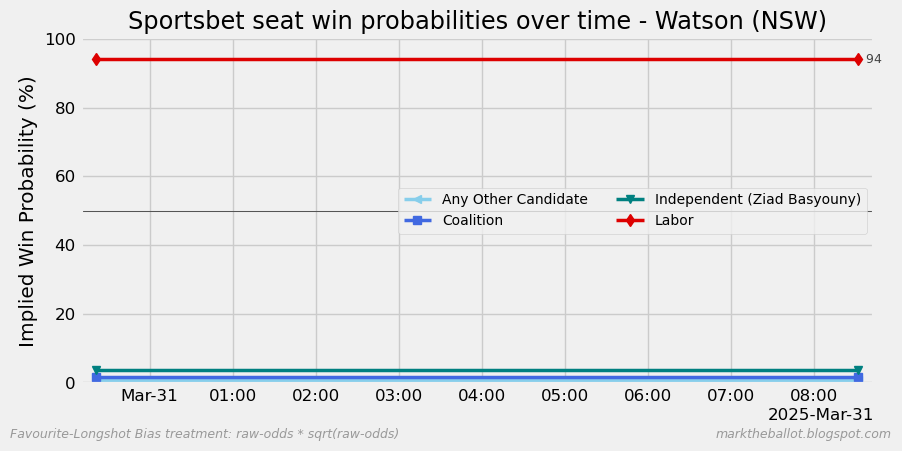

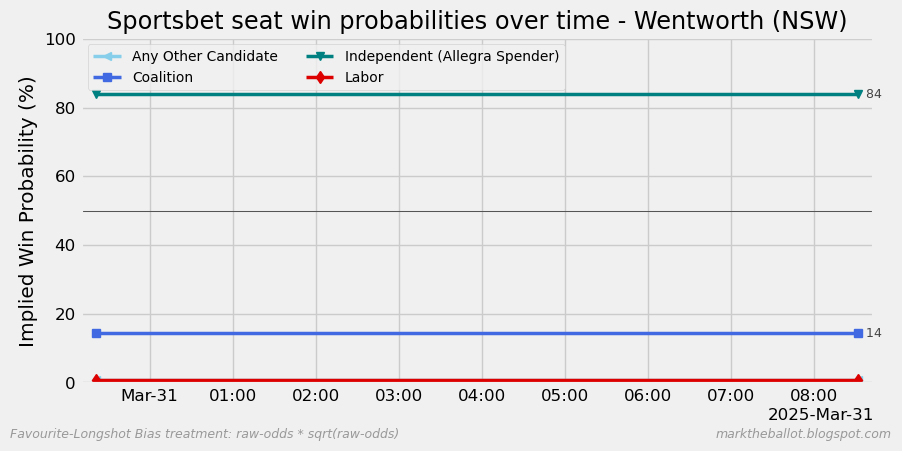

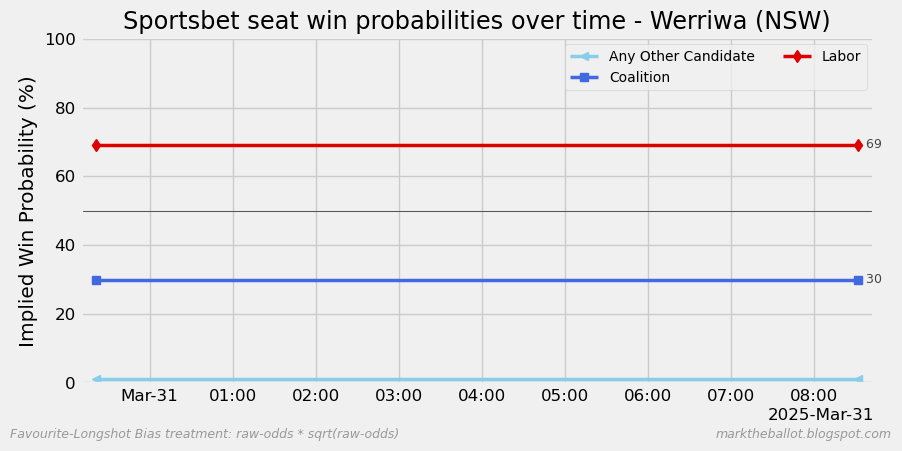

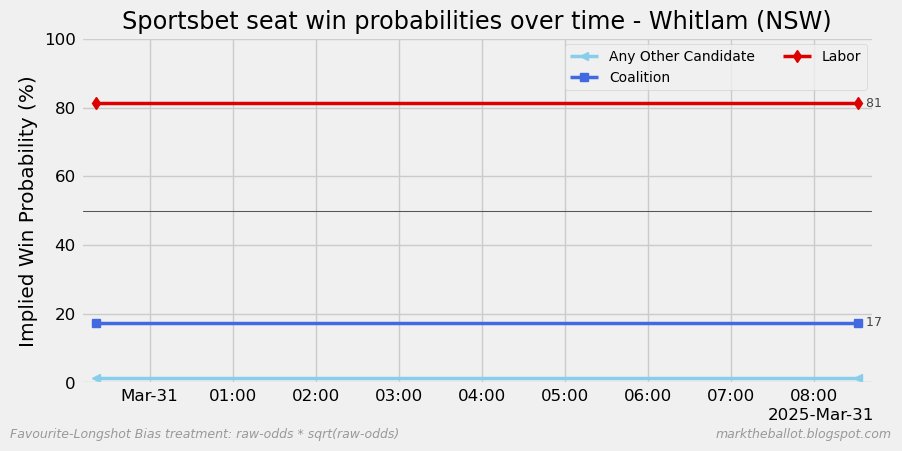

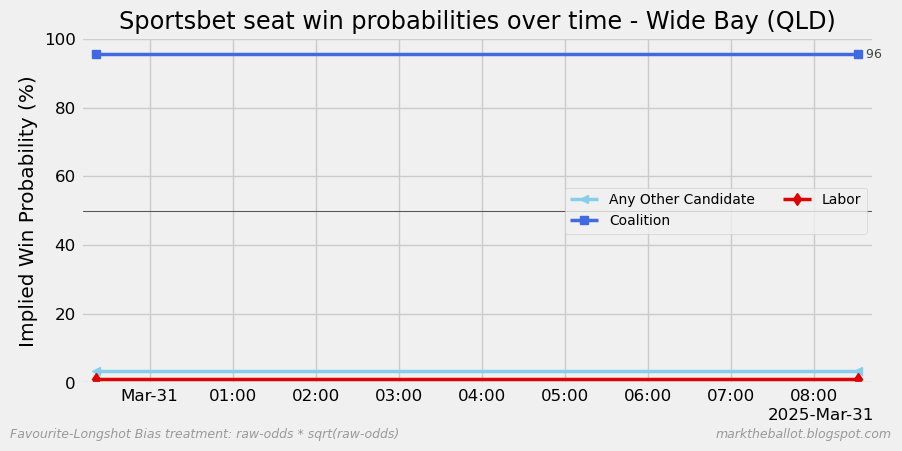

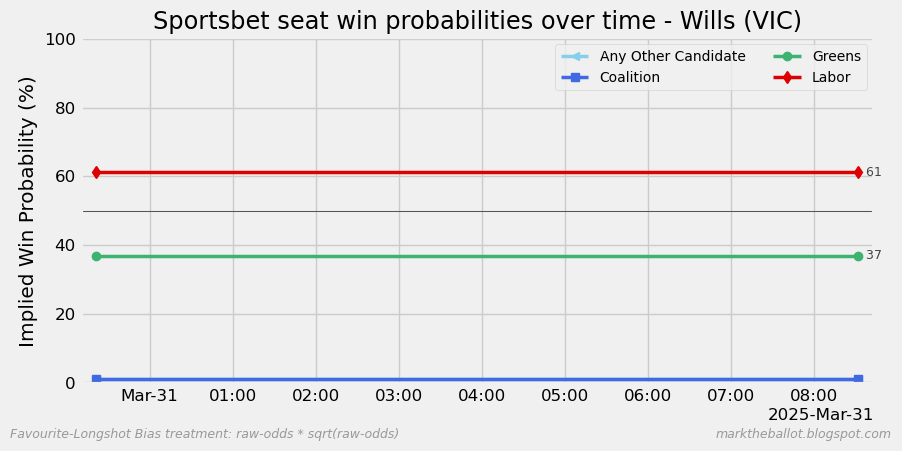

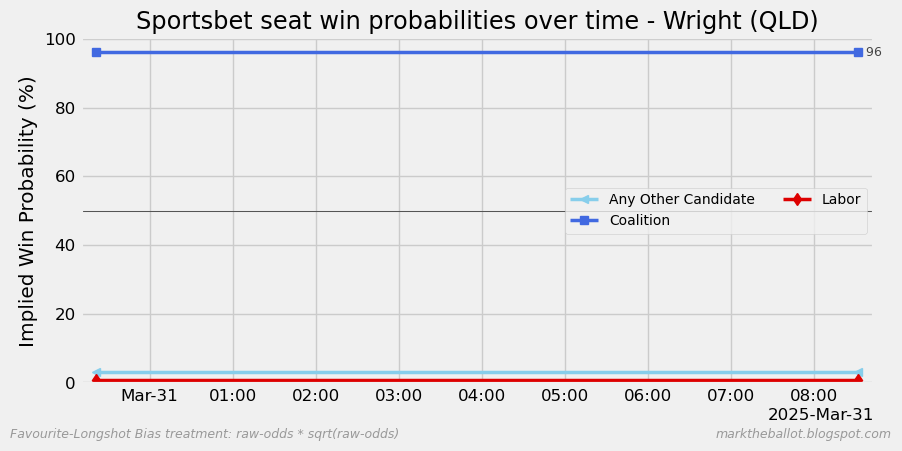

In [9]:


def plot_seat(df:pd.DataFrame, seat:str) -> None:
    """
    Plot the seat probabilities for a given seat.
    Arguments:
    df: pd.DataFrame - The dataframe containing the betting data.
    seat: str - The seat to plot.
    """

    # get seat probabilities - treat for favourite-longshot bias
    seat_probs, flb_method = calc_probability(df, seat)

    # plot
    fig, ax = plt.subplots()
    for i, column in enumerate(seat_probs.columns):
        c, m = colourise(column)
        ax.plot(
            seat_probs.index, 
            seat_probs[column], 
            markersize=6,
            lw=2.5, 
            color=c, 
            marker=m, 
            label=column
        )
        if seat_probs[column].iloc[-1] > 10:
            ax.text(
                seat_probs.index[-1], 
                seat_probs[column].iloc[-1], 
                f'  {seat_probs[column].iloc[-1]:.0f}', 
                fontsize=9, 
                color="#444444",
                ha='left', 
                va='center'
            )
    plotting.finalise_plot(
        ax, 
        title=f'Sportsbet seat win probabilities over time - {seat}', 
        ylabel='Implied Win Probability (%)',
        lfooter=flb_method,
        rfooter='marktheballot.blogspot.com',
        legend={'loc': 'best', 'ncol': 2, 'fontsize': 'small'},
        ylim=(-0.5, 100.5),
        y50=True,
        show=True,
    )


def plot_all_seats():
    # produce plots
    for seat in betting_df.seat.unique():
        plot_seat(betting_df, seat)


plot_all_seats()

## Finished

In [10]:
print("finished")

finished
